# Plot Generation Suitability

This notebook creates plots comparing the available generation in 2050 for solar and wind compared the target generation needed to achieve Net Zero.

## Imports

In [38]:
import pandas as pd
import geopandas as gpd
import numpy as np
import plotly.express as px
import kaleido
import matplotlib.pyplot as plt
import os
from matplotlib.gridspec import GridSpec
from matplotlib.lines import Line2D
from matplotlib.patches import ConnectionPatch
import math

## Data Paths

In [3]:
# data dir
data_dir = os.path.join(os.path.dirname(os.getcwd()), 'data')

# output data
output_data_dir = os.path.join(data_dir, 'output_data')

# input data dir
input_data_dir = os.path.join(data_dir, 'input_data')

# output figure dir
fig_dir = os.path.join(os.path.dirname(os.getcwd()), 'figures')

# path to suitability case df
suitability_data_path = os.path.join(output_data_dir, f'capacity_factor_case_2050.csv')

# western interconnection shapefile
wecc_shp_path = os.path.join(input_data_dir, 'wecc_boundary_shp', 'wecc_boundary.shp')

# transmission shapefile
transmission_path = os.path.join(input_data_dir, 'wecc_transmission_shp', 'wecc_transmission_250kv.shp')
                                 

## Functions

## Collect Data

In [4]:
state_abbr = {'WA': 'washington',
              'NM':'new_mexico',
              'CA': 'california',
              'OR': 'oregon',
              'ID':'idaho',
              'NV': 'nevada',
              'MT': 'montana',
              'AZ':'arizona',
              'CO': 'colorado',
              'UT':'utah',
              'WY':'wyoming'}

# https://jgcri.github.io/gcam-doc/v6.0/gcam-usa.html
gcam_trading_regions = {
             'arizona': 'SW Grid',
             'california': 'CA Grid',
             'colorado': 'SW Grid',
             'idaho': 'NW Grid',
             'montana': 'NW Grid',
             'new_mexico': 'SW Grid',
             'nevada': 'NW Grid',
             'oregon': 'NW Grid',
             'utah': 'NW Grid',
             'washington': 'NW Grid',
             'wyoming': 'SW Grid'}

# Define the sorted order of scenarios in the plot
sorter = {'baseline':"1", 
          'dac':"2", 
          'farmland':"3", 
          'env_1':"4", 
          'env_1_1km':"5", 
          'env_1_5km':"6", 
          'env_1_10km':"7", 
          'env_2':"8", 
          'env_2_1km':"9", 
          'env_2_5km':"10", 
          'env_2_10km':"11", 
           'env_3':"12", 
          'env_3_1km':"13", 
          'env_3_5km':"14", 
          'env_3_10km':"15", 
          'dac_farm_env1':"16", 
           'dac_farm_env2':"17", 
          'dac_farm_env3':"18", 
          'dac_farm_env1_1km':"19", 
           'dac_farm_env2_1km':"20", 
          'dac_farm_env3_1km':"21", 
          'dac_farm_env1_5km':"22", 
           'dac_farm_env2_5km':"23", 
          'dac_farm_env3_5km':"24", 
          'dac_farm_env1_10km':"25", 
           'dac_farm_env2_10km':"26",  
          'dac_farm_env3_10km':"27", 
         }

# Create the dictionary that defines the order for sorting
sorterIndex = dict(zip(sorter, range(len(sorter))))

### Prep shapefiles

In [5]:
# read western interconnection shapefile
wecc_shp = gpd.read_file(wecc_shp_path)
wecc_shp['trading_region'] = wecc_shp['STATE_ABBR'].map(state_abbr).map(gcam_trading_regions)
state_shp = wecc_shp.copy()
wecc_shp = wecc_shp.dissolve(by='trading_region', as_index=False)

# read transmission shapefile
transmission = gpd.read_file(transmission_path)

In [61]:
#read case results
base_df = pd.read_csv((os.path.join(output_data_dir, 'capacity_factor_analysis_2050.csv')))
base_df['case_number'] = base_df['case'].map(sorter)
base_df['label'] = base_df['case_number'] + '. ' + base_df['case']

### Sort and Group Data - Base power density

In [62]:
# gcam trading region case
wind_trading = base_df[base_df.technology == 'Wind_120m'].copy()
wind_trading = wind_trading[wind_trading.power_density_mw == 12]
wind_trading = wind_trading.groupby(['gcam_trading_region', 'case','case_number', 'label'], as_index=False).sum()
wind_trading['Rank'] = wind_trading['case'].map(sorterIndex)
wind_trading.sort_values(['Rank'], ascending = [False], inplace = True)
wind_trading['target_generation_twh'] = wind_trading['target_generation_mwh'] / 1000000
wind_trading['total_generation_twh'] = wind_trading['total_generation_mwh'] / 1000000
wind_trading['diff'] = (wind_trading['total_generation_twh'] - wind_trading['target_generation_twh'])/wind_trading['target_generation_twh']
trading_region_list = sorted(list(wind_trading.gcam_trading_region.unique()))
wind_trading_case_list = (list(wind_trading.case.unique()))

solar_trading = base_df[base_df.technology == 'Solar PV'].copy()
solar_trading = solar_trading[solar_trading.power_density_mw == 30].copy()
solar_trading = solar_trading.groupby(['gcam_trading_region', 'case', 'case_number', 'label'], as_index=False).sum()
solar_trading['Rank'] = solar_trading['case'].map(sorterIndex)
solar_trading.sort_values(['Rank'], ascending = [False], inplace = True)
solar_trading['target_generation_twh'] = solar_trading['target_generation_mwh'] / 1000000
solar_trading['total_generation_twh'] = solar_trading['total_generation_mwh'] / 1000000
solar_trading['diff'] = (solar_trading['total_generation_twh'] - solar_trading['target_generation_twh'])/solar_trading['target_generation_twh']
trading_region_list = sorted(list(solar_trading.gcam_trading_region.unique()))
solar_trading_case_list = (list(solar_trading.case.unique()))

## Figure 6 - GCAM-USA Trading Region Comparison with Base Power Density assumptions

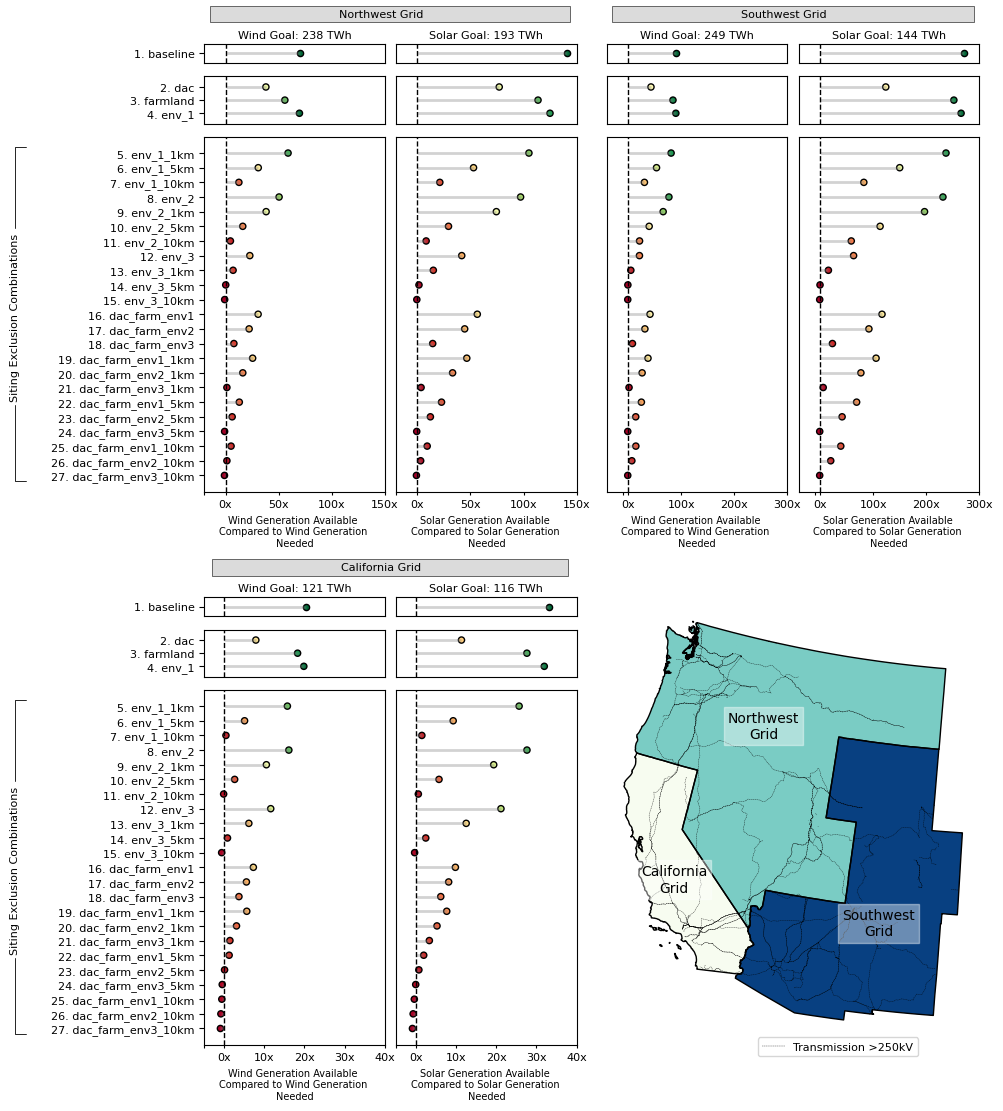

In [63]:
height = 13
width = 10

fig = plt.figure()
fig.set_figheight(height)
fig.set_figwidth(width)

spec = GridSpec(ncols=5, 
                nrows=7,
                width_ratios=[.25, .25, .01 , .25,.25], 
                wspace=0.08,
                hspace=0.1,
                height_ratios=[.05, .12, .9, .2, .05, .12, .9])


# top row set
ax_1a1 =fig.add_subplot(spec[0,0])
ax_1a2 =fig.add_subplot(spec[1,0])
ax_1a3 =fig.add_subplot(spec[2,0])

ax_1b1 =fig.add_subplot(spec[0,1])
ax_1b2 =fig.add_subplot(spec[1,1])
ax_1b3 =fig.add_subplot(spec[2,1])


# sw grid wind
ax_2a1 =fig.add_subplot(spec[0,3])
ax_2a2 =fig.add_subplot(spec[1,3])
ax_2a3 =fig.add_subplot(spec[2,3])

# sw grid solar
ax_2b1 =fig.add_subplot(spec[0,4])
ax_2b2 =fig.add_subplot(spec[1,4])
ax_2b3 =fig.add_subplot(spec[2,4])

# filler row
ax_filler = fig.add_subplot(spec[3,:])

# second row set
# ca wind
ax_3a1 =fig.add_subplot(spec[4,0])
ax_3a2 =fig.add_subplot(spec[5,0])
ax_3a3 =fig.add_subplot(spec[6,0])

# ca solar
ax_3b1 =fig.add_subplot(spec[4,1])
ax_3b2 =fig.add_subplot(spec[5,1])
ax_3b3 =fig.add_subplot(spec[6,1])

#map
ax_map =fig.add_subplot(spec[4:,3:])


### Settings ###
dot_cmap = 'RdYlGn'
dot_edgecolor = 'black'
dot_size=20
hline_alpha=.35
hlinew = 2
hlinecolor='grey'

###########################
##### Northwest Grid ######
###########################

x=1.03
y=2.75
ax_1a1.annotate(f"                                    Northwest Grid                                         ", 
               xy=(x, y), xytext=(x, y), xycoords='axes fraction', 
                    fontsize=8, ha='center', va='top', bbox=dict(boxstyle='square', fc='lightgray', 
                                                                 lw=.5, alpha=.8, color='black'))
# --------------------
### Northwest WIND ###
# --------------------

region = 'NW Grid'
df = wind_trading
plot_df = df[df.gcam_trading_region == region]

x_val_max = plot_df['diff'].max() + 10
x_val_min = plot_df['diff'].min() - 10


vmax =max(plot_df.total_generation_twh.max(), plot_df.target_generation_twh.max())

# Baseline dots
plot_df1 = plot_df[plot_df.case == 'baseline']
my_range=range(1,len(plot_df1.index)+1)
ax=ax_1a1
ax.hlines(y=my_range, xmin=0, xmax=plot_df1['diff'], color=hlinecolor, alpha=hline_alpha, lw=hlinew)
ax.scatter(plot_df1['diff'], my_range, c=plot_df1['total_generation_twh'], s = dot_size, edgecolor=dot_edgecolor, cmap=dot_cmap, vmin=0, vmax=vmax)
ax.axvline(x = 0, linestyle='dashed', color = 'black', lw=1)
ax.set_yticks(my_range)
ax.set_yticklabels(list(plot_df1.label.unique()))
plt.setp(ax.get_yticklabels(), size=8)
ax.tick_params(axis='x',which='both', bottom=True, top=False, labelbottom=True, size=2, labelsize=8)
ax.set_xlim(left=-20, right=150)
ax.annotate(f"Wind Goal: {int(round(plot_df['target_generation_twh'].mean(), 0))} TWh", xy=(.5, 1.03), xytext=(.5, 1.7), xycoords='axes fraction', 
                    fontsize=8, ha='center', va='top')
ax.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False, size=2, labelsize=8)

# Existing dots
plot_df2 = plot_df[plot_df.case.isin(['dac', 'farmland', 'env_1'])]
my_range=range(1,len(plot_df2.index)+1)
ax=ax_1a2
ax.hlines(y=my_range, xmin=0, xmax=plot_df2['diff'], color=hlinecolor, alpha=hline_alpha, lw=hlinew)
ax.scatter(plot_df2['diff'], my_range, c=plot_df2['total_generation_twh'], s = dot_size, edgecolor=dot_edgecolor, cmap=dot_cmap, vmin=0, vmax=vmax)
ax.axvline(x = 0, linestyle='dashed', color = 'black', lw=1)
ax.set_yticks(my_range)
ax.set_yticklabels(list(plot_df2.label.unique()))
plt.setp(ax.get_yticklabels(), size=8)
ax.set_xlim(left=-20, right=150)
ax.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False, size=2, labelsize=8)
ax.margins(0.4)  

# Contribution dots
plot_df3 = plot_df[~plot_df.case.isin(['baseline', 'dac', 'farmland', 'env_1'])]
my_range=range(1,len(plot_df3.index)+1)
ax=ax_1a3
ax.hlines(y=my_range, xmin=0, xmax=plot_df3['diff'], color=hlinecolor, alpha=hline_alpha, lw=hlinew)
ax.scatter(plot_df3['diff'], my_range, c=plot_df3['total_generation_twh'], s = dot_size, edgecolor=dot_edgecolor, alpha=1 , cmap=dot_cmap, vmin=0, vmax=vmax)
ax.axvline(x = 0, linestyle='dashed', color = 'black', lw=1)
ax.set_yticks(my_range)
ax.set_yticklabels(list(plot_df3.label.unique()))
plt.setp(ax.get_yticklabels(), size=8)
ax.tick_params(axis='x',which='both', bottom=True, top=False, labelbottom=True, size=2, labelsize=8)
ax.set_xlim(left=-20, right=150)
ax.set_xticks(ticks=[-20,0,50, 100, 150], labels=['','0x','50x', '100x', '150x'])

#######

# --------------------
### Northwest SOLAR ###
# --------------------

region = 'NW Grid'
df = solar_trading
plot_df = df[df.gcam_trading_region == region]

x_val_max = plot_df['diff'].max() + 10
x_val_min = plot_df['diff'].min() - 10


vmax =max(plot_df.total_generation_twh.max(), plot_df.target_generation_twh.max())

# Baseline dots
plot_df1 = plot_df[plot_df.case == 'baseline']
my_range=range(1,len(plot_df1.index)+1)
ax=ax_1b1
ax.hlines(y=my_range, xmin=0, xmax=plot_df1['diff'], color=hlinecolor, alpha=hline_alpha, lw=hlinew)
ax.scatter(plot_df1['diff'], my_range, c=plot_df1['total_generation_twh'], s = dot_size, edgecolor=dot_edgecolor, cmap=dot_cmap, vmin=0, vmax=vmax)
ax.axvline(x = 0, linestyle='dashed', color = 'black', lw=1)
ax.set_yticks(my_range)
plt.setp(ax.get_yticklabels(), size=8)
ax.tick_params(axis='x',which='both', bottom=True, top=False, labelbottom=True, size=2, labelsize=8)
ax.tick_params(axis='y',which='both', bottom=False, top=False, left=False, labelleft=False, labelbottom=False)
ax.set_xlim(left=-20, right=150)
ax.annotate(f"Solar Goal: {int(round(plot_df['target_generation_twh'].mean(), 0))} TWh", xy=(.5, 1.03), xytext=(.5, 1.7), xycoords='axes fraction', 
                    fontsize=8, ha='center', va='top')
ax.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False, size=2, labelsize=8)

# Existing dots
plot_df2 = plot_df[plot_df.case.isin(['dac', 'farmland', 'env_1'])]
my_range=range(1,len(plot_df2.index)+1)
ax=ax_1b2
ax.hlines(y=my_range, xmin=0, xmax=plot_df2['diff'], color=hlinecolor, alpha=hline_alpha, lw=hlinew)
ax.scatter(plot_df2['diff'], my_range, c=plot_df2['total_generation_twh'], s = dot_size, edgecolor=dot_edgecolor, cmap=dot_cmap, vmin=0, vmax=vmax)
ax.axvline(x = 0, linestyle='dashed', color = 'black', lw=1)
ax.set_yticks(my_range)
ax.tick_params(axis='y',which='both', bottom=False, top=False, left=False, labelleft=False, labelbottom=False)
plt.setp(ax.get_yticklabels(), size=8)
ax.set_xlim(left=-20, right=150)
ax.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False, size=2, labelsize=8)
ax.margins(0.4)  

# Contribution dots
plot_df3 = plot_df[~plot_df.case.isin(['baseline', 'dac', 'farmland', 'env_1'])]
my_range=range(1,len(plot_df3.index)+1)
ax=ax_1b3
ax.hlines(y=my_range, xmin=0, xmax=plot_df3['diff'], color=hlinecolor, alpha=hline_alpha, lw=hlinew)
ax.scatter(plot_df3['diff'], my_range, c=plot_df3['total_generation_twh'], s = dot_size, edgecolor=dot_edgecolor, alpha=1 , cmap=dot_cmap, vmin=0, vmax=vmax)
ax.axvline(x = 0, linestyle='dashed', color = 'black', lw=1)
ax.set_yticks(my_range)
ax.tick_params(axis='y',which='both', bottom=False, top=False, left=False, labelleft=False, labelbottom=False)
plt.setp(ax.get_yticklabels(), size=8)
ax.tick_params(axis='x',which='both', bottom=True, top=False, labelbottom=True, size=2, labelsize=8)
ax.set_xlim(left=-20, right=150)
ax.set_xticks(ticks=[-20,0,50, 100, 150], labels=['','0x','50x', '100x', '150x'])

#######

###########################
##### Southwest Grid ######
###########################

x=1.03
y=2.75
ax_2a1.annotate(f"                                    Southwest Grid                                         ", 
               xy=(x, y), xytext=(x, y), xycoords='axes fraction', 
                    fontsize=8, ha='center', va='top', bbox=dict(boxstyle='square', fc='lightgray', 
                                                                 lw=.5, alpha=.8, color='black'))
# --------------------
### Southwest WIND ###
# --------------------

region = 'SW Grid'
df = wind_trading
plot_df = df[df.gcam_trading_region == region]

x_val_max = plot_df['diff'].max() + 10
x_val_min = plot_df['diff'].min() - 10


vmax =max(plot_df.total_generation_twh.max(), plot_df.target_generation_twh.max())

# Baseline dots
plot_df1 = plot_df[plot_df.case == 'baseline']
my_range=range(1,len(plot_df1.index)+1)
ax=ax_2a1
ax.hlines(y=my_range, xmin=0, xmax=plot_df1['diff'], color=hlinecolor, alpha=hline_alpha, lw=hlinew)
ax.scatter(plot_df1['diff'], my_range, c=plot_df1['total_generation_twh'], s = dot_size, edgecolor=dot_edgecolor, cmap=dot_cmap, vmin=0, vmax=vmax)
ax.axvline(x = 0, linestyle='dashed', color = 'black', lw=1)
ax.set_yticks(my_range)
ax.tick_params(axis='x',which='both', bottom=True, top=False, labelbottom=True, size=2, labelsize=8)
ax.tick_params(axis='y',which='both', bottom=False, top=False, left=False, labelleft=False, labelbottom=False)
ax.set_xlim(left=-40, right=300)
ax.annotate(f"Wind Goal: {int(round(plot_df['target_generation_twh'].mean(), 0))} TWh", xy=(.5, 1.03), xytext=(.5, 1.7), xycoords='axes fraction', 
                    fontsize=8, ha='center', va='top')
ax.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False, size=2, labelsize=8)

# Existing dots
plot_df2 = plot_df[plot_df.case.isin(['dac', 'farmland', 'env_1'])]
my_range=range(1,len(plot_df2.index)+1)
ax=ax_2a2
ax.hlines(y=my_range, xmin=0, xmax=plot_df2['diff'], color=hlinecolor, alpha=hline_alpha, lw=hlinew)
ax.scatter(plot_df2['diff'], my_range, c=plot_df2['total_generation_twh'], s = dot_size, edgecolor=dot_edgecolor, cmap=dot_cmap, vmin=0, vmax=vmax)
ax.axvline(x = 0, linestyle='dashed', color = 'black', lw=1)
ax.set_yticks(my_range)
ax.set_xlim(left=-40, right=300)
ax.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False, size=2, labelsize=8)
ax.tick_params(axis='y',which='both', bottom=False, top=False, left=False, labelleft=False, labelbottom=False)
ax.margins(0.4)  

# Contribution dots
plot_df3 = plot_df[~plot_df.case.isin(['baseline', 'dac', 'farmland', 'env_1'])]
my_range=range(1,len(plot_df3.index)+1)
ax=ax_2a3
ax.hlines(y=my_range, xmin=0, xmax=plot_df3['diff'], color=hlinecolor, alpha=hline_alpha, lw=hlinew)
ax.scatter(plot_df3['diff'], my_range, c=plot_df3['total_generation_twh'], s = dot_size, edgecolor=dot_edgecolor, alpha=1 , cmap=dot_cmap, vmin=0, vmax=vmax)
ax.axvline(x = 0, linestyle='dashed', color = 'black', lw=1)
ax.set_yticks(my_range)
ax.tick_params(axis='x',which='both', bottom=True, top=False, labelbottom=True, size=2, labelsize=8)
ax.tick_params(axis='y',which='both', bottom=False, top=False, left=False, labelleft=False, labelbottom=False)
ax.set_xlim(left=-40, right=300)
ax.set_xticks(ticks=[-10, 0, 100, 200, 300], labels=['','0x', '100x', '200x', '300x'])

#######

# --------------------
### Southwest SOLAR ###
# --------------------

df = solar_trading
plot_df = df[df.gcam_trading_region == region]

x_val_max = plot_df['diff'].max() + 10
x_val_min = plot_df['diff'].min() - 10


vmax =max(plot_df.total_generation_twh.max(), plot_df.target_generation_twh.max())

# Baseline dots
plot_df1 = plot_df[plot_df.case == 'baseline']
my_range=range(1,len(plot_df1.index)+1)
ax=ax_2b1
ax.hlines(y=my_range, xmin=0, xmax=plot_df1['diff'], color=hlinecolor, alpha=hline_alpha, lw=hlinew)
ax.scatter(plot_df1['diff'], my_range, c=plot_df1['total_generation_twh'], s = dot_size, edgecolor=dot_edgecolor, cmap=dot_cmap, vmin=0, vmax=vmax)
ax.axvline(x = 0, linestyle='dashed', color = 'black', lw=1)
ax.set_yticks(my_range)
plt.setp(ax.get_yticklabels(), size=8)
ax.tick_params(axis='x',which='both', bottom=True, top=False, labelbottom=True, size=2, labelsize=8)
ax.tick_params(axis='y',which='both', bottom=False, top=False, left=False, labelleft=False, labelbottom=False)
ax.set_xlim(left=-40, right=300)
ax.annotate(f"Solar Goal: {int(round(plot_df['target_generation_twh'].mean(), 0))} TWh", xy=(.5, 1.03), xytext=(.5, 1.7), xycoords='axes fraction', 
                    fontsize=8, ha='center', va='top')
ax.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False, size=2, labelsize=8)

# Existing dots
plot_df2 = plot_df[plot_df.case.isin(['dac', 'farmland', 'env_1'])]
my_range=range(1,len(plot_df2.index)+1)
ax=ax_2b2
ax.hlines(y=my_range, xmin=0, xmax=plot_df2['diff'], color=hlinecolor, alpha=hline_alpha, lw=hlinew)
ax.scatter(plot_df2['diff'], my_range, c=plot_df2['total_generation_twh'], s = dot_size, edgecolor=dot_edgecolor, cmap=dot_cmap, vmin=0, vmax=vmax)
ax.axvline(x = 0, linestyle='dashed', color = 'black', lw=1)
ax.set_yticks(my_range)
ax.tick_params(axis='y',which='both', bottom=False, top=False, left=False, labelleft=False, labelbottom=False)
plt.setp(ax.get_yticklabels(), size=8)
ax.set_xlim(left=-40, right=300)
ax.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False, size=2, labelsize=8)
ax.margins(0.4)  

# Contribution dots
plot_df3 = plot_df[~plot_df.case.isin(['baseline', 'dac', 'farmland', 'env_1'])]
my_range=range(1,len(plot_df3.index)+1)
ax=ax_2b3
ax.hlines(y=my_range, xmin=0, xmax=plot_df3['diff'], color=hlinecolor, alpha=hline_alpha, lw=hlinew)
ax.scatter(plot_df3['diff'], my_range, c=plot_df3['total_generation_twh'], s = dot_size, edgecolor=dot_edgecolor, alpha=1 , cmap=dot_cmap, vmin=0, vmax=vmax)
ax.axvline(x = 0, linestyle='dashed', color = 'black', lw=1)
ax.set_yticks(my_range)
ax.tick_params(axis='y',which='both', bottom=False, top=False, left=False, labelleft=False, labelbottom=False)
plt.setp(ax.get_yticklabels(), size=8)
ax.tick_params(axis='x',which='both', bottom=True, top=False, labelbottom=True, size=2, labelsize=8)
ax.set_xlim(left=-40, right=300)
ax.set_xticks(ticks=[-10, 0, 100, 200, 300], labels=['','0x', '100x', '200x', '300x'])


###########################
##### CA Grid ######
###########################

x=1.03
y=2.75
ax_3a1.annotate(f"                                    California Grid                                         ", 
               xy=(x, y), xytext=(x, y), xycoords='axes fraction', 
                    fontsize=8, ha='center', va='top', bbox=dict(boxstyle='square', fc='lightgray', 
                                                                 lw=.5, alpha=.8, color='black'))
# --------------------
### CA WIND ###
# --------------------

region = 'CA Grid'
df = wind_trading
plot_df = df[df.gcam_trading_region == region]

x_val_max = plot_df['diff'].max() + 10
x_val_min = plot_df['diff'].min() - 10


vmax =max(plot_df.total_generation_twh.max(), plot_df.target_generation_twh.max())

# Baseline dots
plot_df1 = plot_df[plot_df.case == 'baseline']
my_range=range(1,len(plot_df1.index)+1)
ax=ax_3a1
ax.hlines(y=my_range, xmin=0, xmax=plot_df1['diff'], color=hlinecolor, alpha=hline_alpha, lw=hlinew)
ax.scatter(plot_df1['diff'], my_range, c=plot_df1['total_generation_twh'], s = dot_size, edgecolor=dot_edgecolor, cmap=dot_cmap, vmin=0, vmax=vmax)
ax.axvline(x = 0, linestyle='dashed', color = 'black', lw=1)
ax.set_yticks(my_range)
ax.set_yticklabels(list(plot_df1.label.unique()))
plt.setp(ax.get_yticklabels(), size=8)
ax.tick_params(axis='x',which='both', bottom=True, top=False, labelbottom=True, size=2, labelsize=8)
ax.set_xlim(left=-5, right=40)
ax.annotate(f"Wind Goal: {int(round(plot_df['target_generation_twh'].mean(), 0))} TWh", xy=(.5, 1.03), xytext=(.5, 1.7), xycoords='axes fraction', 
                    fontsize=8, ha='center', va='top')
ax.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False, size=2, labelsize=8)

# Existing dots
plot_df2 = plot_df[plot_df.case.isin(['dac', 'farmland', 'env_1'])]
my_range=range(1,len(plot_df2.index)+1)
ax=ax_3a2
ax.hlines(y=my_range, xmin=0, xmax=plot_df2['diff'], color=hlinecolor, alpha=hline_alpha, lw=hlinew)
ax.scatter(plot_df2['diff'], my_range, c=plot_df2['total_generation_twh'], s = dot_size, edgecolor=dot_edgecolor, cmap=dot_cmap, vmin=0, vmax=vmax)
ax.axvline(x = 0, linestyle='dashed', color = 'black', lw=1)
ax.set_yticks(my_range)
ax.set_yticklabels(list(plot_df2.label.unique()))
plt.setp(ax.get_yticklabels(), size=8)
ax.set_xlim(left=-5, right=40)
ax.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False, size=2, labelsize=8)
ax.margins(0.4)  

# Contribution dots
plot_df3 = plot_df[~plot_df.case.isin(['baseline', 'dac', 'farmland', 'env_1'])]
my_range=range(1,len(plot_df3.index)+1)
ax=ax_3a3
ax.hlines(y=my_range, xmin=0, xmax=plot_df3['diff'], color=hlinecolor, alpha=hline_alpha, lw=hlinew)
ax.scatter(plot_df3['diff'], my_range, c=plot_df3['total_generation_twh'], s = dot_size, edgecolor=dot_edgecolor, alpha=1 , cmap=dot_cmap, vmin=0, vmax=vmax)
ax.axvline(x = 0, linestyle='dashed', color = 'black', lw=1)
ax.set_yticks(my_range)
ax.set_yticklabels(list(plot_df3.label.unique()))
plt.setp(ax.get_yticklabels(), size=8)
ax.tick_params(axis='x',which='both', bottom=True, top=False, labelbottom=True, size=2, labelsize=8)
ax.set_xlim(left=-5, right=40)
ax.set_xticks(ticks=[-5, 0, 10, 20, 30, 40], labels=['','0x','10x', '20x', '30x', '40x'])

#######

# --------------------
### CA SOLAR ###
# --------------------

df = solar_trading
plot_df = df[df.gcam_trading_region == region]

x_val_max = plot_df['diff'].max() + 10
x_val_min = plot_df['diff'].min() - 10


vmax =max(plot_df.total_generation_twh.max(), plot_df.target_generation_twh.max())

# Baseline dots
plot_df1 = plot_df[plot_df.case == 'baseline']
my_range=range(1,len(plot_df1.index)+1)
ax=ax_3b1
ax.hlines(y=my_range, xmin=0, xmax=plot_df1['diff'], color=hlinecolor, alpha=hline_alpha, lw=hlinew)
ax.scatter(plot_df1['diff'], my_range, c=plot_df1['total_generation_twh'], s = dot_size, edgecolor=dot_edgecolor, cmap=dot_cmap, vmin=0, vmax=vmax)
ax.axvline(x = 0, linestyle='dashed', color = 'black', lw=1)
ax.set_yticks(my_range)
plt.setp(ax.get_yticklabels(), size=8)
ax.tick_params(axis='x',which='both', bottom=True, top=False, labelbottom=True, size=2, labelsize=8)
ax.tick_params(axis='y',which='both', bottom=False, top=False, left=False, labelleft=False, labelbottom=False)
ax.set_xlim(left=-5, right=40)
ax.annotate(f"Solar Goal: {int(round(plot_df['target_generation_twh'].mean(), 0))} TWh", xy=(.5, 1.03), xytext=(.5, 1.7), xycoords='axes fraction', 
                    fontsize=8, ha='center', va='top')
ax.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False, size=2, labelsize=8)

# Existing dots
plot_df2 = plot_df[plot_df.case.isin(['dac', 'farmland', 'env_1'])]
my_range=range(1,len(plot_df2.index)+1)
ax=ax_3b2
ax.hlines(y=my_range, xmin=0, xmax=plot_df2['diff'], color=hlinecolor, alpha=hline_alpha, lw=hlinew)
ax.scatter(plot_df2['diff'], my_range, c=plot_df2['total_generation_twh'], s = dot_size, edgecolor=dot_edgecolor, cmap=dot_cmap, vmin=0, vmax=vmax)
ax.axvline(x = 0, linestyle='dashed', color = 'black', lw=1)
ax.set_yticks(my_range)
ax.tick_params(axis='y',which='both', bottom=False, top=False, left=False, labelleft=False, labelbottom=False)
plt.setp(ax.get_yticklabels(), size=8)
ax.set_xlim(left=-5, right=40)
ax.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False, size=2, labelsize=8)
ax.margins(0.4)  

# Contribution dots
plot_df3 = plot_df[~plot_df.case.isin(['baseline', 'dac', 'farmland', 'env_1'])]
my_range=range(1,len(plot_df3.index)+1)
ax=ax_3b3
ax.hlines(y=my_range, xmin=0, xmax=plot_df3['diff'], color=hlinecolor, alpha=hline_alpha, lw=hlinew)
ax.scatter(plot_df3['diff'], my_range, c=plot_df3['total_generation_twh'], s = dot_size, edgecolor=dot_edgecolor, alpha=1 , cmap=dot_cmap, vmin=0, vmax=vmax)
ax.axvline(x = 0, linestyle='dashed', color = 'black', lw=1)
ax.set_yticks(my_range)
ax.tick_params(axis='y',which='both', bottom=False, top=False, left=False, labelleft=False, labelbottom=False)
plt.setp(ax.get_yticklabels(), size=8)
ax.tick_params(axis='x',which='both', bottom=True, top=False, labelbottom=True, size=2, labelsize=8)
ax.set_xlim(left=-5, right=40)
ax.set_xticks(ticks=[-5,0, 10, 20, 30, 40], labels=['','0x', '10x','20x', '30x','40x'])

#######


#### MAP #######

volt = Line2D([0], [0], color='black',linestyle='dashed', lw=.25, label='Transmission >250kV')
wecc_shp.plot(ax=ax_map,  column='trading_region', cmap='GnBu')
wecc_shp.boundary.plot(ax=ax_map, lw=1, color='black')
transmission.plot(ax=ax_map, color='black',linestyle='dashed', lw=.25)
ax_map.legend(handles=[volt], fontsize=8, title_fontsize = 8, loc='lower right', ncol=1, facecolor='white', bbox_to_anchor=(.85, -.05))


# region labels
ax_map.set_axis_off()
x=.42
y=.75
ax_map.annotate(f"Northwest\nGrid", xy=(x, y), xytext=(x, y), xycoords='axes fraction', 
                    fontsize=10, ha='center', va='top', bbox=dict(boxstyle='square', fc='white', alpha=.4, color='white'))
x=.73
y=.3
ax_map.annotate(f"Southwest\nGrid", xy=(x, y), xytext=(x, y), xycoords='axes fraction', 
                    fontsize=10, ha='center', va='top', bbox=dict(boxstyle='square', fc='white', alpha=.4, color='white'))
x=.18
y=.4 
ax_map.annotate(f"California\nGrid", xy=(x, y), xytext=(x, y), xycoords='axes fraction', 
                    fontsize=10, ha='center', va='top', bbox=dict(boxstyle='square', fc='white', alpha=.4, color='white'))


# X-axis Unit Labels
for ax in [ax_1a3,  ax_2a3, ax_3a3]:
    ax.set_xlabel('Wind Generation Available \nCompared to Wind Generation \nNeeded', size=7)
for ax in [ax_1b3,  ax_2b3, ax_3b3]:
    ax.set_xlabel('Solar Generation Available \nCompared to Solar Generation \nNeeded', size=7)

ax_map.set_axis_off()
ax_filler.set_axis_off()

#### Side labels

ax_1a3.annotate('Siting Exclusion Combinations', xy=(-1.05, .70), xytext=(-1.05, .73), xycoords='axes fraction', 
            fontsize=8, ha='center', va='top', rotation = 90,
            bbox=dict(boxstyle='square', fc='white', color='white'),
            arrowprops=dict(arrowstyle=']-, widthA=15, lengthA=1, angleA=90',lw=.6, color='k'))

ax_3a3.annotate('Siting Exclusion Combinations', xy=(-1.05, .70), xytext=(-1.05, .73), xycoords='axes fraction', 
            fontsize=8, ha='center', va='top', rotation = 90,
            bbox=dict(boxstyle='square', fc='white', color='white'),
            arrowprops=dict(arrowstyle=']-, widthA=15, lengthA=1, angleA=90',lw=.6, color='k'))

plt.savefig(os.path.join(fig_dir, 'fig_5_generation_suitability_sensitivity_analysis.png'), dpi=300)


plt.show()

### State-level Available Generation at Base Power Density

In [45]:
# state case
wind = base_df[base_df.technology == 'Wind_120m'].copy()
wind = wind[wind.power_density_mw == 12].copy()
wind['Rank'] = wind['case'].map(sorterIndex)
wind.sort_values(['Rank'], ascending = [False], inplace = True)
wind['target_generation_twh'] = wind['target_generation_mwh'] / 1000000
wind['total_generation_twh'] = wind['total_generation_mwh'] / 1000000
wind['diff'] = (wind['total_generation_twh'] - wind['target_generation_twh']) / wind['target_generation_twh']
region_list = sorted(list(wind.region_name.unique()))
case_list = (list(wind.case.unique()))

solar = base_df[base_df.technology == 'Solar PV'].copy()
solar['Rank'] = solar['case'].map(sorterIndex)
solar = solar[solar.power_density_mw == 30].copy()
solar.sort_values(['Rank'], ascending = [False], inplace = True)
solar['target_generation_twh'] = solar['target_generation_mwh'] / 1000000
solar['total_generation_twh'] = solar['total_generation_mwh'] / 1000000
solar['diff'] =  (solar['total_generation_twh'] - solar['target_generation_twh'])/solar['target_generation_twh']
region_list = sorted(list(solar.region_name.unique()))
case_list = (list(solar.case.unique()))

## Figure SI-5 Available solar generation (dots) compared to generation needed to achieve net zero under various siting exclusion scenarios by individual Western US State and total Western US region.

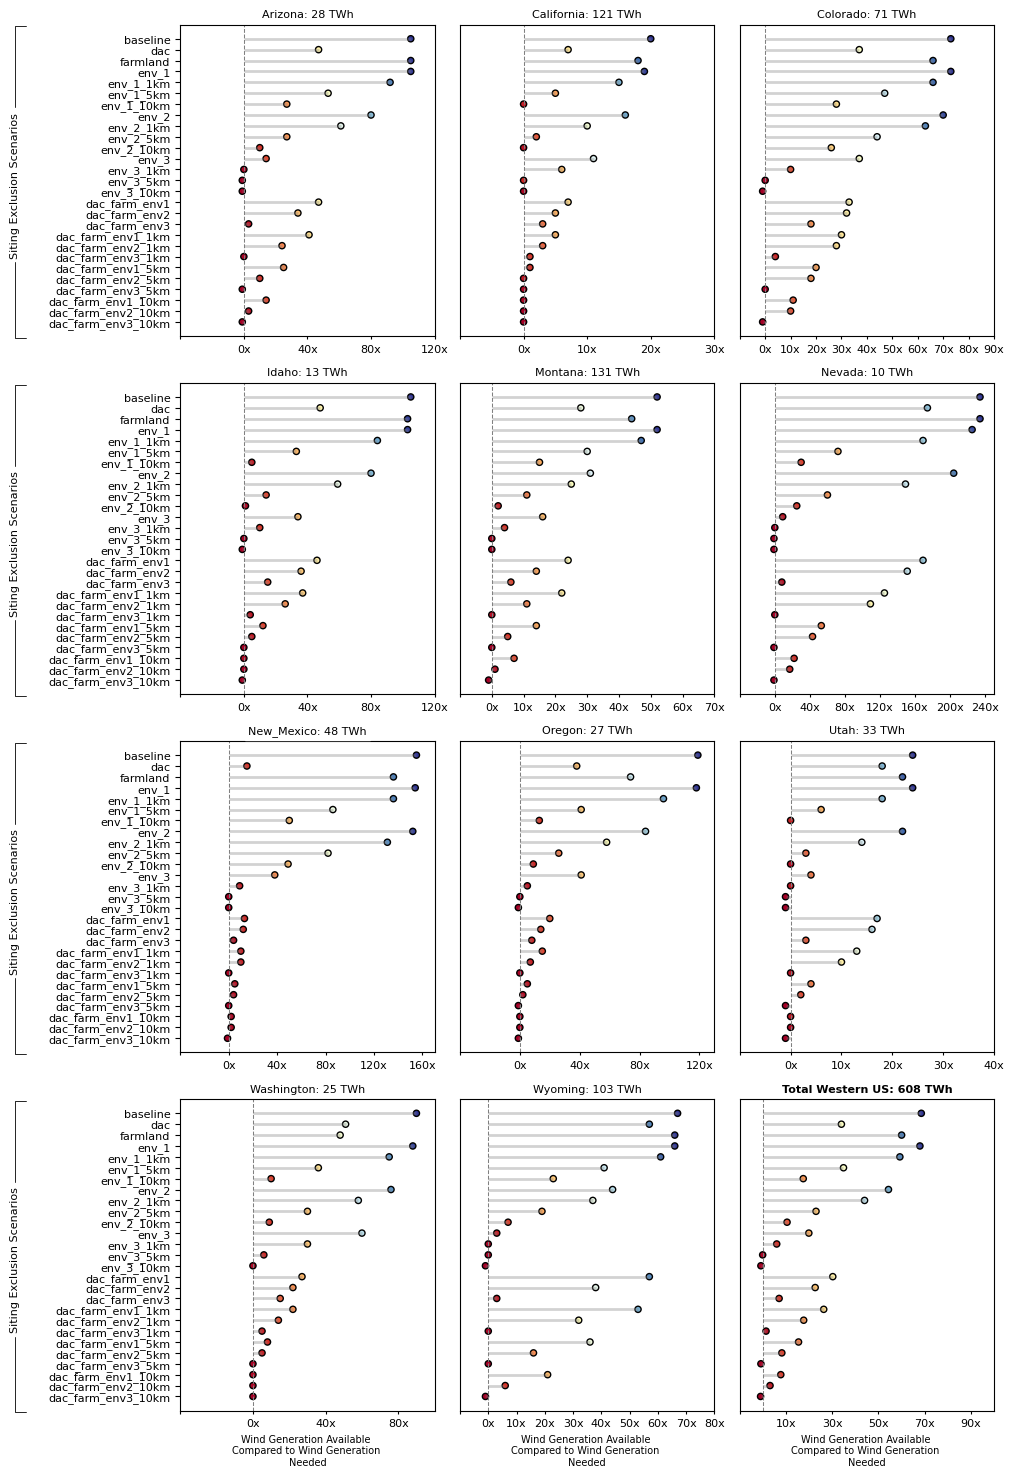

In [49]:
height = 18
width = 10.5

fig = plt.figure()
fig.set_figheight(height)
fig.set_figwidth(width)

spec = GridSpec(ncols=3, 
                nrows=4,
                width_ratios=[.33, .33, .33], 
                wspace=0.1,
                hspace=0.15,
                height_ratios=[.25, .25, .25, .25])


ax_1a =fig.add_subplot(spec[0,0])
ax_1b =fig.add_subplot(spec[0,1])
ax_1c =fig.add_subplot(spec[0,2])

ax_2a =fig.add_subplot(spec[1,0])
ax_2b =fig.add_subplot(spec[1,1])
ax_2c =fig.add_subplot(spec[1,2])

ax_3a =fig.add_subplot(spec[2,0])
ax_3b =fig.add_subplot(spec[2,1])
ax_3c =fig.add_subplot(spec[2,2])

ax_4a =fig.add_subplot(spec[3,0])
ax_4b =fig.add_subplot(spec[3,1])
ax_4c =fig.add_subplot(spec[3,2])

#ax_4c.set_axis_off()
ax_list = [ax_1a, ax_1b, ax_1c, ax_2a, ax_2b, ax_2c, ax_3a, ax_3b, ax_3c, ax_4a, ax_4b]

import matplotlib.ticker as mtick
from matplotlib.ticker import MaxNLocator
for i in range(len(region_list)):

    region = region_list[i]
    plot_df = wind[wind.region_name == region].copy()
    plot_df['diff'] = plot_df['diff'].astype(int)
    my_range=range(1,len(plot_df.index)+1)
    
    vmax =max(plot_df.total_generation_twh.max(), plot_df.target_generation_twh.max())

    x_val_max = (int(math.ceil(plot_df['diff'].max() / 10.0)) * 10 ) + 10
    x_val_min = - 10

    ax_list[i].hlines(y=my_range, xmin=0, xmax=plot_df['diff'], color='grey', alpha=.35, lw=2)
    ax_list[i].scatter(plot_df['diff'], my_range, c=plot_df['total_generation_twh'], s = 20, edgecolor='black', alpha=1 , 
                cmap='RdYlBu', vmin=0, vmax=vmax)

    ax_list[i].set_xlim(right=x_val_max, left=x_val_min)
    ax_list[i].xaxis.set_major_locator(MaxNLocator(integer=True))
    
    ax_list[i].axvline(x =0, linestyle='dashed', color = 'gray', lw=.75)
    ax_list[i].set_yticks(my_range)
    ax_list[i].set_yticklabels(case_list)
    plt.setp(ax_list[i].get_yticklabels(), size=8)
    ax_list[i].tick_params(axis='x',which='both', bottom=True, top=False, labelbottom=True, size=2, labelsize=8)

    if region_list[i] in ['nevada', 'oregon', 'idaho', 'new_mexico', 'arizona', 'washington']:
        step = 40
        x_tick_list = list(range(-40, x_val_max+1, step))
        x_tick_label = [" "]
        
    else:
        step = 10
        x_tick_list = list(range(-10, x_val_max+1, step))
        x_tick_label = [" "]
    
    for label in x_tick_list:
        if label <0:
            pass
        else:
            x_tick_label.append(str(label)+'x')
    
    ax_list[i].set_xticks(ticks=x_tick_list, labels=x_tick_label)

    
    if i in [1, 2, 4, 5, 7, 8, 10]:
        ax_list[i].tick_params(axis='y',which='both', bottom=False, top=False, left=False, labelleft=False, labelbottom=False)
    ax_list[i].annotate(f"{region.title()}: {int(round(plot_df['target_generation_twh'].mean(), 0))} TWh", xy=(.5, 1.05), xytext=(.5, 1.05), xycoords='axes fraction', 
                        fontsize=8, ha='center', va='top',
            bbox=dict(boxstyle='square', fc='white', color='white'))

west_df = wind.copy()
west_df = west_df[west_df.technology == 'Wind_120m'].copy()
west_df = west_df[west_df.power_density_mw == 12]
west_df = west_df[['case', 'Rank','diff', 'total_generation_twh', 'target_generation_twh']].groupby(['case', 'Rank'], as_index=False).sum()
west_df['diff'] = (west_df['total_generation_twh'] - west_df['target_generation_twh']) / west_df['target_generation_twh']
west_df.sort_values(['Rank'], ascending = [False], inplace = True)
my_range=range(1,len(west_df.index)+1)
    
vmax =max(west_df.total_generation_twh.max(), west_df.target_generation_twh.max())

ax_4c.hlines(y=my_range, xmin=0, xmax=west_df['diff'], color='grey', alpha=.35, lw=2)
ax_4c.scatter(west_df['diff'], my_range, c=west_df['total_generation_twh'], s = 20, edgecolor='black', alpha=1 ,cmap='RdYlBu', vmin=-100, vmax=vmax)
ax_4c.axvline(x = 0, linestyle='dashed', color = 'gray', lw=.75)
ax_4c.tick_params(axis='y',which='both', bottom=False, top=False, left=False, labelleft=False, labelbottom=False)
ax_4c.tick_params(axis='x',which='both', bottom=True, top=False, labelbottom=True, size=2, labelsize=8)
ax_4c.annotate(f"Total Western US: {int(round(west_df['target_generation_twh'].mean(), 0))} TWh", xy=(.5, 1.05), xytext=(.5, 1.05), xycoords='axes fraction', 
                        fontsize=8, ha='center', va='top', weight='bold',
                        bbox=dict(boxstyle='square', fc='white', color='white'))
x_tick_list = list(range(-10, int(vmax)+1, 20))
x_tick_label = [" "]
for label in x_tick_list:
    if label <0:
        pass
    else:
        x_tick_label.append(str(label)+'x')
ax_4c.set_xticks(ticks=x_tick_list, labels=x_tick_label)

ax_4a.set_xlabel('Wind Generation Available \nCompared to Wind Generation \nNeeded', size=7)
ax_4b.set_xlabel('Wind Generation Available \nCompared to Wind Generation \nNeeded', size=7)
ax_4c.set_xlabel('Wind Generation Available \nCompared to Wind Generation \nNeeded', size=7)


ax_4c.set_xlim(right=100, left=-10)


ax_1a.annotate('Siting Exclusion Scenarios', xy=(-.65, .72), xytext=(-.65, .72), xycoords='axes fraction', 
            fontsize=8, ha='center', va='top', rotation = 90,
            bbox=dict(boxstyle='square', fc='white', color='white'),
            arrowprops=dict(arrowstyle=']-, widthA=14, lengthA=1, angleA=90',lw=.6, color='k'))

ax_2a.annotate('Siting Exclusion Scenarios', xy=(-.65, .72), xytext=(-.65, .72), xycoords='axes fraction', 
            fontsize=8, ha='center', va='top', rotation = 90,
            bbox=dict(boxstyle='square', fc='white', color='white'),
            arrowprops=dict(arrowstyle=']-, widthA=14, lengthA=1, angleA=90',lw=.6, color='k'))
ax_3a.annotate('Siting Exclusion Scenarios', xy=(-.65, .72), xytext=(-.65, .72), xycoords='axes fraction', 
            fontsize=8, ha='center', va='top', rotation = 90, 
            bbox=dict(boxstyle='square', fc='white', color='white'),
            arrowprops=dict(arrowstyle=']-, widthA=14, lengthA=1, angleA=90',lw=.6, color='k'))

ax_4a.annotate('Siting Exclusion Scenarios', xy=(-.65, .72), xytext=(-.65, .72), xycoords='axes fraction', 
            fontsize=8, ha='center', va='top', rotation = 90,
            bbox=dict(boxstyle='square', fc='white', color='white'),
            arrowprops=dict(arrowstyle=']-, widthA=14, lengthA=1, angleA=90',lw=.6, color='k'))
plt.savefig(os.path.join(fig_dir, 'fig_si-5_wind_state_generation_analysis.png'), dpi=300)

plt.show()

## Figure SI-6 Available solar generation (dots) compared to generation needed to achieve net zero under various siting exclusion scenarios by individual Western US State and total Western US region. 

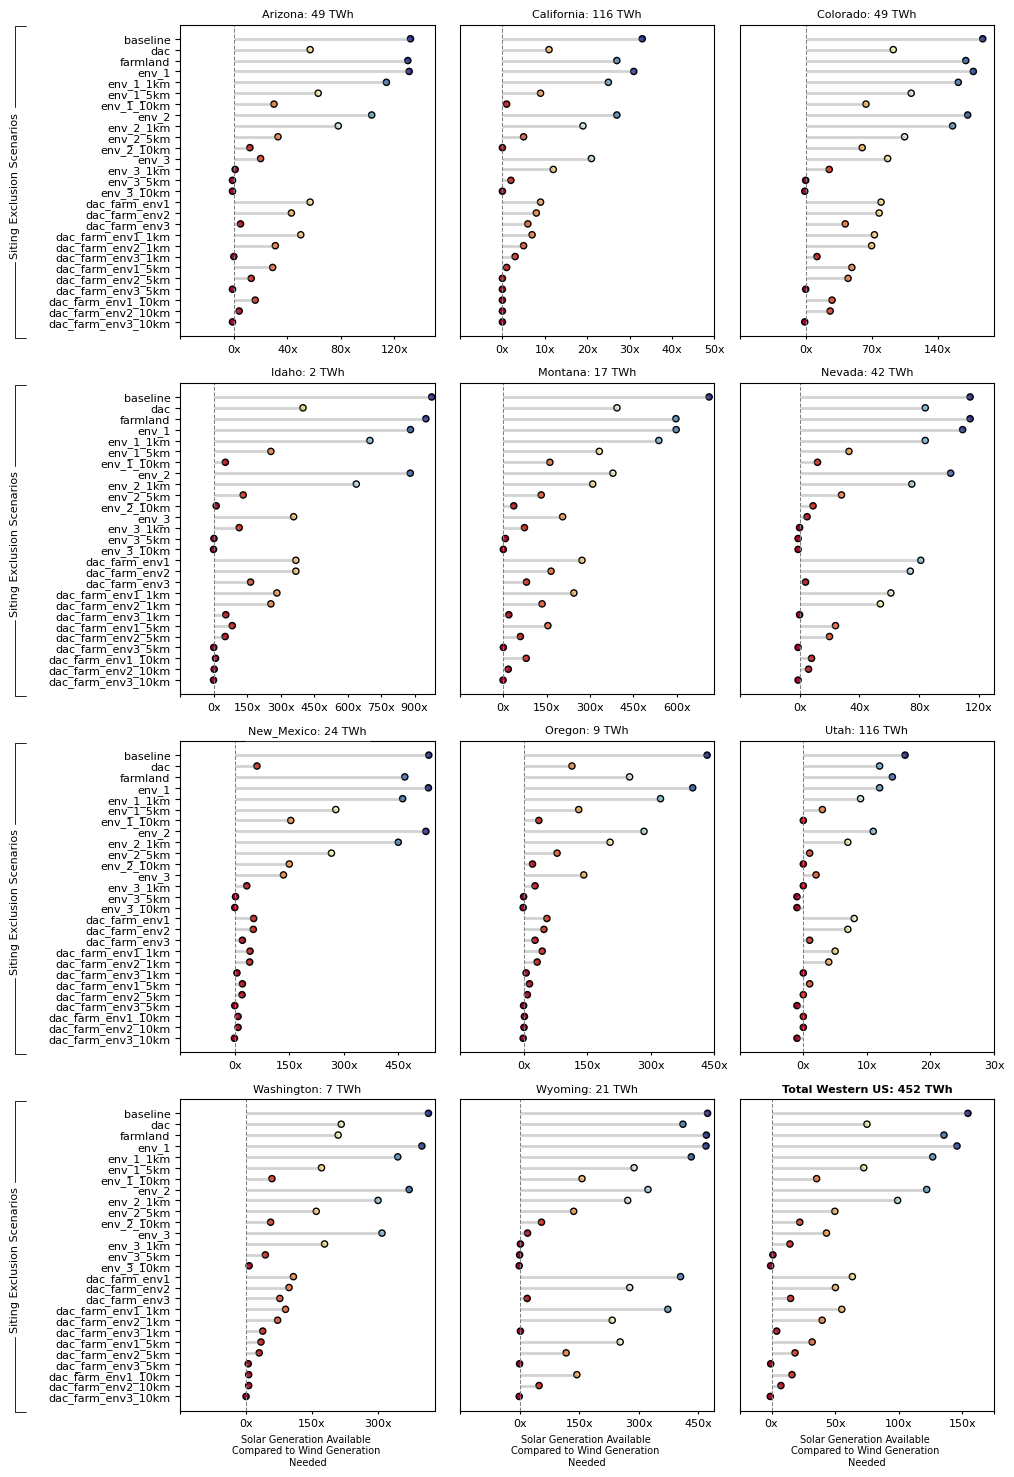

In [51]:
height = 18
width = 10.5

fig = plt.figure()
fig.set_figheight(height)
fig.set_figwidth(width)

spec = GridSpec(ncols=3, 
                nrows=4,
                width_ratios=[.33, .33, .33], 
                wspace=0.1,
                hspace=0.15,
                height_ratios=[.25, .25, .25, .25])


ax_1a =fig.add_subplot(spec[0,0])
ax_1b =fig.add_subplot(spec[0,1])
ax_1c =fig.add_subplot(spec[0,2])

ax_2a =fig.add_subplot(spec[1,0])
ax_2b =fig.add_subplot(spec[1,1])
ax_2c =fig.add_subplot(spec[1,2])

ax_3a =fig.add_subplot(spec[2,0])
ax_3b =fig.add_subplot(spec[2,1])
ax_3c =fig.add_subplot(spec[2,2])

ax_4a =fig.add_subplot(spec[3,0])
ax_4b =fig.add_subplot(spec[3,1])
ax_4c =fig.add_subplot(spec[3,2])

ax_list = [ax_1a, ax_1b, ax_1c, ax_2a, ax_2b, ax_2c, ax_3a, ax_3b, ax_3c, ax_4a, ax_4b]


for i in range(len(region_list)):

    region = region_list[i]
    plot_df = solar[solar.region_name == region].copy()
    plot_df['diff'] = plot_df['diff'].astype(int)
    my_range=range(1,len(plot_df.index)+1)
    
    vmax =max(plot_df.total_generation_twh.max(), plot_df.target_generation_twh.max())

    x_val_max = (int(math.ceil(plot_df['diff'].max() / 10.0)) * 10 ) + 10
    x_val_min = - 10

    ax_list[i].hlines(y=my_range, xmin=0, xmax=plot_df['diff'], color='grey', alpha=.35, lw=2)
    ax_list[i].scatter(plot_df['diff'], my_range, c=plot_df['total_generation_twh'], s = 20, edgecolor='black', alpha=1 , 
                cmap='RdYlBu', vmin=0, vmax=vmax)

    # # Add title and axis names
    ax_list[i].set_xlim(right=x_val_max, left=x_val_min)
    ax_list[i].xaxis.set_major_locator(MaxNLocator(integer=True))    
    ax_list[i].axvline(x =0, linestyle='dashed', color = 'gray', lw=.75)
    ax_list[i].set_yticks(my_range)
    ax_list[i].set_yticklabels(case_list)
    plt.setp(ax_list[i].get_yticklabels(), size=8)
    ax_list[i].tick_params(axis='x',which='both', bottom=True, top=False, labelbottom=True, size=2, labelsize=8)


    if region_list[i] in ['nevada', 'arizona', ]:
        step = 40
    elif region_list[i] in ['colorado']:
        step = 70
    elif region_list[i] in ['montana', 'idaho',  'new_mexico', 'oregon', 'washington', 'wyoming']:
        step = 150
    else:
        step = 10
    x_tick_list = list(range(-step, x_val_max+1, step))    
        

    x_tick_label = [" "]    
    for label in x_tick_list:
        if label <0:
            pass
        else:
            x_tick_label.append(str(label)+'x')
    
    ax_list[i].set_xticks(ticks=x_tick_list, labels=x_tick_label)

    
    if i in [1, 2, 4, 5, 7, 8, 10]:
        ax_list[i].tick_params(axis='y',which='both', bottom=False, top=False, left=False, labelleft=False, labelbottom=False)
    ax_list[i].annotate(f"{region.title()}: {int(round(plot_df['target_generation_twh'].mean(), 0))} TWh", xy=(.5, 1.05), xytext=(.5, 1.05), xycoords='axes fraction', 
                        fontsize=8, ha='center', va='top',
            bbox=dict(boxstyle='square', fc='white', color='white'))

west_df = solar.copy()
west_df = west_df[west_df.technology == 'Solar PV'].copy()
west_df = west_df[west_df.power_density_mw == 30]
west_df = west_df[['case', 'Rank','diff', 'total_generation_twh', 'target_generation_twh']].groupby(['case', 'Rank'], as_index=False).sum()
west_df['diff'] = (west_df['total_generation_twh'] - west_df['target_generation_twh']) / west_df['target_generation_twh']
west_df.sort_values(['Rank'], ascending = [False], inplace = True)
my_range=range(1,len(west_df.index)+1)
    
vmax =max(west_df.total_generation_twh.max(), west_df.target_generation_twh.max())

ax_4c.hlines(y=my_range, xmin=0, xmax=west_df['diff'], color='grey', alpha=.35, lw=2)
ax_4c.scatter(west_df['diff'], my_range, c=west_df['total_generation_twh'], s = 20, edgecolor='black', alpha=1 ,cmap='RdYlBu', vmin=-100, vmax=vmax)
ax_4c.axvline(x = 0, linestyle='dashed', color = 'gray', lw=.75)
ax_4c.tick_params(axis='y',which='both', bottom=False, top=False, left=False, labelleft=False, labelbottom=False)
ax_4c.tick_params(axis='x',which='both', bottom=True, top=False, labelbottom=True, size=2, labelsize=8)
ax_4c.annotate(f"Total Western US: {int(round(west_df['target_generation_twh'].mean(), 0))} TWh", xy=(.5, 1.05), xytext=(.5, 1.05), xycoords='axes fraction', 
                        fontsize=8, ha='center', va='top', weight='bold',
                        bbox=dict(boxstyle='square', fc='white', color='white'))

ax_4c.set_xticks(ticks=[-25,0, 50, 100, 150, 175], labels=['','0x', '50x','100x', '150x', ""])

ax_4a.set_xlabel('Solar Generation Available \nCompared to Wind Generation \nNeeded', size=7)
ax_4b.set_xlabel('Solar Generation Available \nCompared to Wind Generation \nNeeded', size=7)
ax_4c.set_xlabel('Solar Generation Available \nCompared to Wind Generation \nNeeded', size=7)




ax_1a.annotate('Siting Exclusion Scenarios', xy=(-.65, .72), xytext=(-.65, .72), xycoords='axes fraction', 
            fontsize=8, ha='center', va='top', rotation = 90,
            bbox=dict(boxstyle='square', fc='white', color='white'),
            arrowprops=dict(arrowstyle=']-, widthA=14, lengthA=1, angleA=90',lw=.6, color='k'))

ax_2a.annotate('Siting Exclusion Scenarios', xy=(-.65, .72), xytext=(-.65, .72), xycoords='axes fraction', 
            fontsize=8, ha='center', va='top', rotation = 90,
            bbox=dict(boxstyle='square', fc='white', color='white'),
            arrowprops=dict(arrowstyle=']-, widthA=14, lengthA=1, angleA=90',lw=.6, color='k'))
ax_3a.annotate('Siting Exclusion Scenarios', xy=(-.65, .72), xytext=(-.65, .72), xycoords='axes fraction', 
            fontsize=8, ha='center', va='top', rotation = 90,
            bbox=dict(boxstyle='square', fc='white', color='white'),
            arrowprops=dict(arrowstyle=']-, widthA=14, lengthA=1, angleA=90',lw=.6, color='k'))

ax_4a.annotate('Siting Exclusion Scenarios', xy=(-.65, .72), xytext=(-.65, .72), xycoords='axes fraction', 
            fontsize=8, ha='center', va='top', rotation = 90,
            bbox=dict(boxstyle='square', fc='white', color='white'),
            arrowprops=dict(arrowstyle=']-, widthA=14, lengthA=1, angleA=90',lw=.6, color='k'))
plt.savefig(os.path.join(fig_dir, 'fig_si-6_solar_state_generation_analysis.png'), dpi=300)

plt.show()

# Power Density Sensitivity case

### Lower Power Density Sensitivity case

In [56]:

# state case
wind = base_df[base_df.technology == 'Wind_120m'].copy()
wind = wind[wind.power_density_mw == 6].copy()
wind['Rank'] = wind['case'].map(sorterIndex)
wind.sort_values(['Rank'], ascending = [False], inplace = True)
wind['target_generation_twh'] = wind['target_generation_mwh'] / 1000000
wind['total_generation_twh'] = wind['total_generation_mwh'] / 1000000
wind['diff'] = (wind['total_generation_twh'] - wind['target_generation_twh']) / wind['target_generation_twh']
region_list = sorted(list(wind.region_name.unique()))
case_list = (list(wind.case.unique()))

solar = base_df[base_df.technology == 'Solar PV'].copy()
solar['Rank'] = solar['case'].map(sorterIndex)
solar = solar[solar.power_density_mw == 15].copy()
solar.sort_values(['Rank'], ascending = [False], inplace = True)
solar['target_generation_twh'] = solar['target_generation_mwh'] / 1000000
solar['total_generation_twh'] = solar['total_generation_mwh'] / 1000000
solar['diff'] =  (solar['total_generation_twh'] - solar['target_generation_twh'])/solar['target_generation_twh']
region_list = sorted(list(solar.region_name.unique()))
case_list = (list(solar.case.unique()))

# gcam trading region case
wind_trading = base_df[base_df.technology == 'Wind_120m'].copy()
wind_trading = wind_trading[wind_trading.power_density_mw == 6]
wind_trading = wind_trading.groupby(['gcam_trading_region', 'case'], as_index=False).sum()
wind_trading['Rank'] = wind_trading['case'].map(sorterIndex)
wind_trading.sort_values(['Rank'], ascending = [False], inplace = True)
wind_trading['target_generation_twh'] = wind_trading['target_generation_mwh'] / 1000000
wind_trading['total_generation_twh'] = wind_trading['total_generation_mwh'] / 1000000
wind_trading['diff'] = (wind_trading['total_generation_twh'] - wind_trading['target_generation_twh'])/wind_trading['target_generation_twh']
trading_region_list = sorted(list(wind_trading.gcam_trading_region.unique()))
wind_trading_case_list = (list(wind_trading.case.unique()))

solar_trading = base_df[base_df.technology == 'Solar PV'].copy()
solar_trading = solar_trading[solar_trading.power_density_mw == 15].copy()
solar_trading = solar_trading.groupby(['gcam_trading_region', 'case'], as_index=False).sum()
solar_trading['Rank'] = solar_trading['case'].map(sorterIndex)
solar_trading.sort_values(['Rank'], ascending = [False], inplace = True)
solar_trading['target_generation_twh'] = solar_trading['target_generation_mwh'] / 1000000
solar_trading['total_generation_twh'] = solar_trading['total_generation_mwh'] / 1000000
solar_trading['diff'] = (solar_trading['total_generation_twh'] - solar_trading['target_generation_twh'])/solar_trading['target_generation_twh']
trading_region_list = sorted(list(solar_trading.gcam_trading_region.unique()))
solar_trading_case_list = (list(solar_trading.case.unique()))

## Figure SI-7, Available wind and solar generation (dots) compared to generation needed to achieve net zero under various siting exclusion scenarios by GCAM-USA electricity trading region under a lower power density assumption

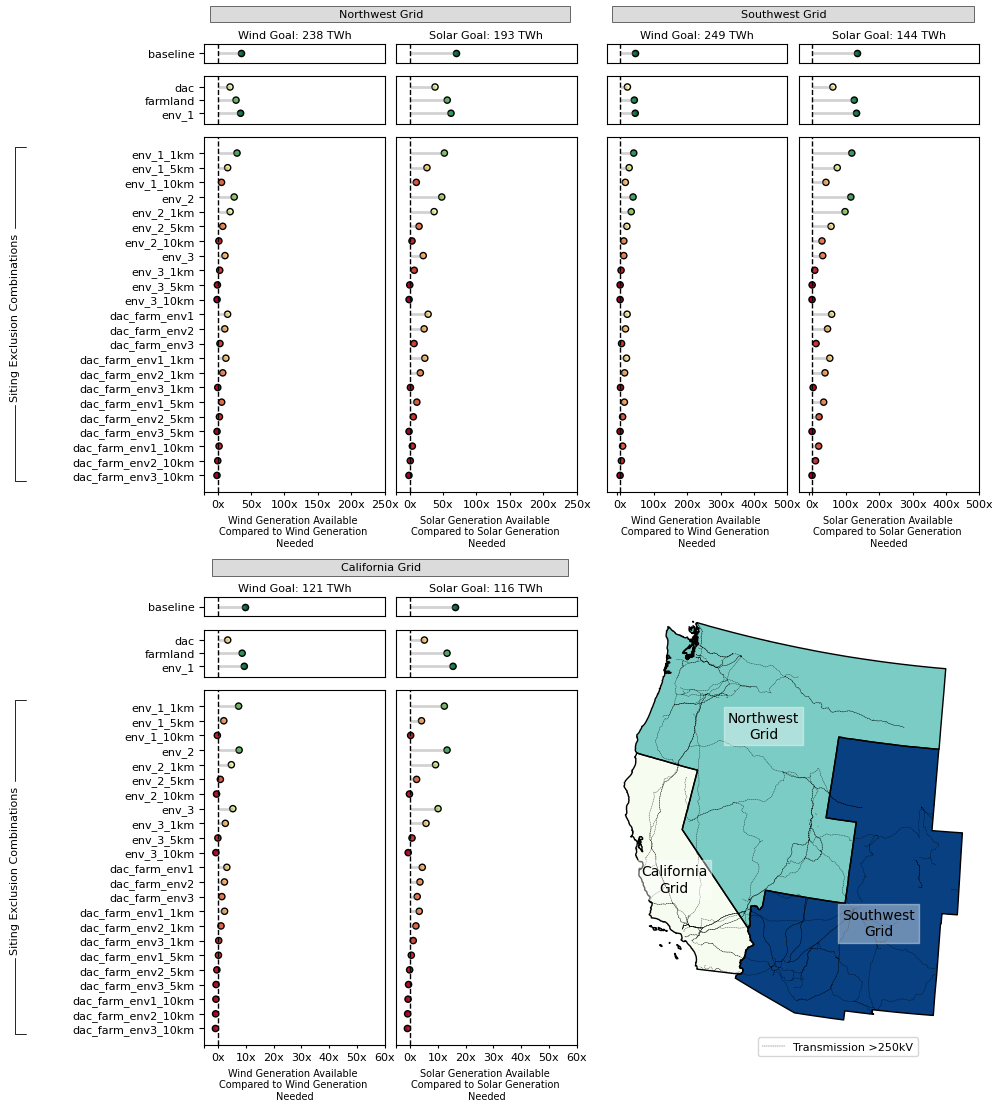

In [57]:
height = 13
width = 10

fig = plt.figure()
fig.set_figheight(height)
fig.set_figwidth(width)

spec = GridSpec(ncols=5, 
                nrows=7,
                width_ratios=[.25, .25, .01 , .25,.25], 
                wspace=0.08,
                hspace=0.1,
                height_ratios=[.05, .12, .9, .2, .05, .12, .9])


# top row set
ax_1a1 =fig.add_subplot(spec[0,0])
ax_1a2 =fig.add_subplot(spec[1,0])
ax_1a3 =fig.add_subplot(spec[2,0])

ax_1b1 =fig.add_subplot(spec[0,1])
ax_1b2 =fig.add_subplot(spec[1,1])
ax_1b3 =fig.add_subplot(spec[2,1])


# sw grid wind
ax_2a1 =fig.add_subplot(spec[0,3])
ax_2a2 =fig.add_subplot(spec[1,3])
ax_2a3 =fig.add_subplot(spec[2,3])

# sw grid solar
ax_2b1 =fig.add_subplot(spec[0,4])
ax_2b2 =fig.add_subplot(spec[1,4])
ax_2b3 =fig.add_subplot(spec[2,4])

# filler row
ax_filler = fig.add_subplot(spec[3,:])

# second row set
# ca wind
ax_3a1 =fig.add_subplot(spec[4,0])
ax_3a2 =fig.add_subplot(spec[5,0])
ax_3a3 =fig.add_subplot(spec[6,0])

# ca solar
ax_3b1 =fig.add_subplot(spec[4,1])
ax_3b2 =fig.add_subplot(spec[5,1])
ax_3b3 =fig.add_subplot(spec[6,1])

#map
ax_map =fig.add_subplot(spec[4:,3:])


### Settings ###
dot_cmap = 'RdYlGn'
dot_edgecolor = 'black'
dot_size=20
hline_alpha=.35
hlinew = 2
hlinecolor='grey'

###########################
##### Northwest Grid ######
###########################

x=1.03
y=2.75
ax_1a1.annotate(f"                                    Northwest Grid                                         ", 
               xy=(x, y), xytext=(x, y), xycoords='axes fraction', 
                    fontsize=8, ha='center', va='top', bbox=dict(boxstyle='square', fc='lightgray', 
                                                                 lw=.5, alpha=.8, color='black'))
# --------------------
### Northwest WIND ###
# --------------------

region = 'NW Grid'
df = wind_trading
plot_df = df[df.gcam_trading_region == region]

x_val_max = plot_df['diff'].max() + 10
x_val_min = plot_df['diff'].min() - 10


vmax =max(plot_df.total_generation_twh.max(), plot_df.target_generation_twh.max())

# Baseline dots
plot_df1 = plot_df[plot_df.case == 'baseline']
my_range=range(1,len(plot_df1.index)+1)
ax=ax_1a1
ax.hlines(y=my_range, xmin=0, xmax=plot_df1['diff'], color=hlinecolor, alpha=hline_alpha, lw=hlinew)
ax.scatter(plot_df1['diff'], my_range, c=plot_df1['total_generation_twh'], s = dot_size, edgecolor=dot_edgecolor, cmap=dot_cmap, vmin=0, vmax=vmax)
ax.axvline(x = 0, linestyle='dashed', color = 'black', lw=1)
ax.set_yticks(my_range)
ax.set_yticklabels(list(plot_df1.case.unique()))
plt.setp(ax.get_yticklabels(), size=8)
ax.tick_params(axis='x',which='both', bottom=True, top=False, labelbottom=True, size=2, labelsize=8)
ax.set_xlim(left=-20, right=250)
ax.annotate(f"Wind Goal: {int(round(plot_df['target_generation_twh'].mean(), 0))} TWh", xy=(.5, 1.03), xytext=(.5, 1.7), xycoords='axes fraction', 
                    fontsize=8, ha='center', va='top')
ax.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False, size=2, labelsize=8)

# Existing dots
plot_df2 = plot_df[plot_df.case.isin(['dac', 'farmland', 'env_1'])]
my_range=range(1,len(plot_df2.index)+1)
ax=ax_1a2
ax.hlines(y=my_range, xmin=0, xmax=plot_df2['diff'], color=hlinecolor, alpha=hline_alpha, lw=hlinew)
ax.scatter(plot_df2['diff'], my_range, c=plot_df2['total_generation_twh'], s = dot_size, edgecolor=dot_edgecolor, cmap=dot_cmap, vmin=0, vmax=vmax)
ax.axvline(x = 0, linestyle='dashed', color = 'black', lw=1)
ax.set_yticks(my_range)
ax.set_yticklabels(list(plot_df2.case.unique()))
plt.setp(ax.get_yticklabels(), size=8)
ax.set_xlim(left=-20, right=250)
ax.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False, size=2, labelsize=8)
ax.margins(0.4)  

# Contribution dots
plot_df3 = plot_df[~plot_df.case.isin(['baseline', 'dac', 'farmland', 'env_1'])]
my_range=range(1,len(plot_df3.index)+1)
ax=ax_1a3
ax.hlines(y=my_range, xmin=0, xmax=plot_df3['diff'], color=hlinecolor, alpha=hline_alpha, lw=hlinew)
ax.scatter(plot_df3['diff'], my_range, c=plot_df3['total_generation_twh'], s = dot_size, edgecolor=dot_edgecolor, alpha=1 , cmap=dot_cmap, vmin=0, vmax=vmax)
ax.axvline(x = 0, linestyle='dashed', color = 'black', lw=1)
ax.set_yticks(my_range)
ax.set_yticklabels(list(plot_df3.case.unique()))
plt.setp(ax.get_yticklabels(), size=8)
ax.tick_params(axis='x',which='both', bottom=True, top=False, labelbottom=True, size=2, labelsize=8)
ax.set_xlim(left=-20, right=250)
ax.set_xticks(ticks=[-20,0,50, 100, 150, 200, 250], labels=['','0x','50x', '100x', '150x', '200x', '250x'])

#######

# --------------------
### Northwest SOLAR ###
# --------------------

region = 'NW Grid'
df = solar_trading
plot_df = df[df.gcam_trading_region == region]

x_val_max = plot_df['diff'].max() + 10
x_val_min = plot_df['diff'].min() - 10


vmax =max(plot_df.total_generation_twh.max(), plot_df.target_generation_twh.max())

# Baseline dots
plot_df1 = plot_df[plot_df.case == 'baseline']
my_range=range(1,len(plot_df1.index)+1)
ax=ax_1b1
ax.hlines(y=my_range, xmin=0, xmax=plot_df1['diff'], color=hlinecolor, alpha=hline_alpha, lw=hlinew)
ax.scatter(plot_df1['diff'], my_range, c=plot_df1['total_generation_twh'], s = dot_size, edgecolor=dot_edgecolor, cmap=dot_cmap, vmin=0, vmax=vmax)
ax.axvline(x = 0, linestyle='dashed', color = 'black', lw=1)
ax.set_yticks(my_range)
plt.setp(ax.get_yticklabels(), size=8)
ax.tick_params(axis='x',which='both', bottom=True, top=False, labelbottom=True, size=2, labelsize=8)
ax.tick_params(axis='y',which='both', bottom=False, top=False, left=False, labelleft=False, labelbottom=False)
ax.set_xlim(left=-20, right=250)
ax.annotate(f"Solar Goal: {int(round(plot_df['target_generation_twh'].mean(), 0))} TWh", xy=(.5, 1.03), xytext=(.5, 1.7), xycoords='axes fraction', 
                    fontsize=8, ha='center', va='top')
ax.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False, size=2, labelsize=8)

# Existing dots
plot_df2 = plot_df[plot_df.case.isin(['dac', 'farmland', 'env_1'])]
my_range=range(1,len(plot_df2.index)+1)
ax=ax_1b2
ax.hlines(y=my_range, xmin=0, xmax=plot_df2['diff'], color=hlinecolor, alpha=hline_alpha, lw=hlinew)
ax.scatter(plot_df2['diff'], my_range, c=plot_df2['total_generation_twh'], s = dot_size, edgecolor=dot_edgecolor, cmap=dot_cmap, vmin=0, vmax=vmax)
ax.axvline(x = 0, linestyle='dashed', color = 'black', lw=1)
ax.set_yticks(my_range)
ax.tick_params(axis='y',which='both', bottom=False, top=False, left=False, labelleft=False, labelbottom=False)
plt.setp(ax.get_yticklabels(), size=8)
ax.set_xlim(left=-20, right=250)
ax.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False, size=2, labelsize=8)
ax.margins(0.4)  

# Contribution dots
plot_df3 = plot_df[~plot_df.case.isin(['baseline', 'dac', 'farmland', 'env_1'])]
my_range=range(1,len(plot_df3.index)+1)
ax=ax_1b3
ax.hlines(y=my_range, xmin=0, xmax=plot_df3['diff'], color=hlinecolor, alpha=hline_alpha, lw=hlinew)
ax.scatter(plot_df3['diff'], my_range, c=plot_df3['total_generation_twh'], s = dot_size, edgecolor=dot_edgecolor, alpha=1 , cmap=dot_cmap, vmin=0, vmax=vmax)
ax.axvline(x = 0, linestyle='dashed', color = 'black', lw=1)
ax.set_yticks(my_range)
ax.tick_params(axis='y',which='both', bottom=False, top=False, left=False, labelleft=False, labelbottom=False)
plt.setp(ax.get_yticklabels(), size=8)
ax.tick_params(axis='x',which='both', bottom=True, top=False, labelbottom=True, size=2, labelsize=8)
ax.set_xlim(left=-20, right=250)
ax.set_xticks(ticks=[-20,0,50, 100, 150, 200, 250], labels=['','0x','50x', '100x', '150x', '200x', '250x'])

#######

###########################
##### Southwest Grid ######
###########################

x=1.03
y=2.75
ax_2a1.annotate(f"                                    Southwest Grid                                         ", 
               xy=(x, y), xytext=(x, y), xycoords='axes fraction', 
                    fontsize=8, ha='center', va='top', bbox=dict(boxstyle='square', fc='lightgray', 
                                                                 lw=.5, alpha=.8, color='black'))
# --------------------
### Southwest WIND ###
# --------------------

region = 'SW Grid'
df = wind_trading
plot_df = df[df.gcam_trading_region == region]

x_val_max = plot_df['diff'].max() + 10
x_val_min = plot_df['diff'].min() - 10


vmax =max(plot_df.total_generation_twh.max(), plot_df.target_generation_twh.max())

# Baseline dots
plot_df1 = plot_df[plot_df.case == 'baseline']
my_range=range(1,len(plot_df1.index)+1)
ax=ax_2a1
ax.hlines(y=my_range, xmin=0, xmax=plot_df1['diff'], color=hlinecolor, alpha=hline_alpha, lw=hlinew)
ax.scatter(plot_df1['diff'], my_range, c=plot_df1['total_generation_twh'], s = dot_size, edgecolor=dot_edgecolor, cmap=dot_cmap, vmin=0, vmax=vmax)
ax.axvline(x = 0, linestyle='dashed', color = 'black', lw=1)
ax.set_yticks(my_range)
ax.tick_params(axis='x',which='both', bottom=True, top=False, labelbottom=True, size=2, labelsize=8)
ax.tick_params(axis='y',which='both', bottom=False, top=False, left=False, labelleft=False, labelbottom=False)
ax.set_xlim(left=-40, right=500)
ax.annotate(f"Wind Goal: {int(round(plot_df['target_generation_twh'].mean(), 0))} TWh", xy=(.5, 1.03), xytext=(.5, 1.7), xycoords='axes fraction', 
                    fontsize=8, ha='center', va='top')
ax.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False, size=2, labelsize=8)

# Existing dots
plot_df2 = plot_df[plot_df.case.isin(['dac', 'farmland', 'env_1'])]
my_range=range(1,len(plot_df2.index)+1)
ax=ax_2a2
ax.hlines(y=my_range, xmin=0, xmax=plot_df2['diff'], color=hlinecolor, alpha=hline_alpha, lw=hlinew)
ax.scatter(plot_df2['diff'], my_range, c=plot_df2['total_generation_twh'], s = dot_size, edgecolor=dot_edgecolor, cmap=dot_cmap, vmin=0, vmax=vmax)
ax.axvline(x = 0, linestyle='dashed', color = 'black', lw=1)
ax.set_yticks(my_range)
ax.set_xlim(left=-40, right=500)
ax.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False, size=2, labelsize=8)
ax.tick_params(axis='y',which='both', bottom=False, top=False, left=False, labelleft=False, labelbottom=False)
ax.margins(0.4)  

# Contribution dots
plot_df3 = plot_df[~plot_df.case.isin(['baseline', 'dac', 'farmland', 'env_1'])]
my_range=range(1,len(plot_df3.index)+1)
ax=ax_2a3
ax.hlines(y=my_range, xmin=0, xmax=plot_df3['diff'], color=hlinecolor, alpha=hline_alpha, lw=hlinew)
ax.scatter(plot_df3['diff'], my_range, c=plot_df3['total_generation_twh'], s = dot_size, edgecolor=dot_edgecolor, alpha=1 , cmap=dot_cmap, vmin=0, vmax=vmax)
ax.axvline(x = 0, linestyle='dashed', color = 'black', lw=1)
ax.set_yticks(my_range)
ax.tick_params(axis='x',which='both', bottom=True, top=False, labelbottom=True, size=2, labelsize=8)
ax.tick_params(axis='y',which='both', bottom=False, top=False, left=False, labelleft=False, labelbottom=False)
ax.set_xlim(left=-40, right=500)
ax.set_xticks(ticks=[-10, 0, 100, 200, 300, 400, 500], labels=['','0x', '100x', '200x', '300x', '400x', '500x'])

#######

# --------------------
### Southwest SOLAR ###
# --------------------

df = solar_trading
plot_df = df[df.gcam_trading_region == region]

x_val_max = plot_df['diff'].max() + 10
x_val_min = plot_df['diff'].min() - 10


vmax =max(plot_df.total_generation_twh.max(), plot_df.target_generation_twh.max())

# Baseline dots
plot_df1 = plot_df[plot_df.case == 'baseline']
my_range=range(1,len(plot_df1.index)+1)
ax=ax_2b1
ax.hlines(y=my_range, xmin=0, xmax=plot_df1['diff'], color=hlinecolor, alpha=hline_alpha, lw=hlinew)
ax.scatter(plot_df1['diff'], my_range, c=plot_df1['total_generation_twh'], s = dot_size, edgecolor=dot_edgecolor, cmap=dot_cmap, vmin=0, vmax=vmax)
ax.axvline(x = 0, linestyle='dashed', color = 'black', lw=1)
ax.set_yticks(my_range)
plt.setp(ax.get_yticklabels(), size=8)
ax.tick_params(axis='x',which='both', bottom=True, top=False, labelbottom=True, size=2, labelsize=8)
ax.tick_params(axis='y',which='both', bottom=False, top=False, left=False, labelleft=False, labelbottom=False)
ax.set_xlim(left=-40, right=500)
ax.annotate(f"Solar Goal: {int(round(plot_df['target_generation_twh'].mean(), 0))} TWh", xy=(.5, 1.03), xytext=(.5, 1.7), xycoords='axes fraction', 
                    fontsize=8, ha='center', va='top')
ax.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False, size=2, labelsize=8)

# Existing dots
plot_df2 = plot_df[plot_df.case.isin(['dac', 'farmland', 'env_1'])]
my_range=range(1,len(plot_df2.index)+1)
ax=ax_2b2
ax.hlines(y=my_range, xmin=0, xmax=plot_df2['diff'], color=hlinecolor, alpha=hline_alpha, lw=hlinew)
ax.scatter(plot_df2['diff'], my_range, c=plot_df2['total_generation_twh'], s = dot_size, edgecolor=dot_edgecolor, cmap=dot_cmap, vmin=0, vmax=vmax)
ax.axvline(x = 0, linestyle='dashed', color = 'black', lw=1)
ax.set_yticks(my_range)
ax.tick_params(axis='y',which='both', bottom=False, top=False, left=False, labelleft=False, labelbottom=False)
plt.setp(ax.get_yticklabels(), size=8)
ax.set_xlim(left=-40, right=500)
ax.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False, size=2, labelsize=8)
ax.margins(0.4)  

# Contribution dots
plot_df3 = plot_df[~plot_df.case.isin(['baseline', 'dac', 'farmland', 'env_1'])]
my_range=range(1,len(plot_df3.index)+1)
ax=ax_2b3
ax.hlines(y=my_range, xmin=0, xmax=plot_df3['diff'], color=hlinecolor, alpha=hline_alpha, lw=hlinew)
ax.scatter(plot_df3['diff'], my_range, c=plot_df3['total_generation_twh'], s = dot_size, edgecolor=dot_edgecolor, alpha=1 , cmap=dot_cmap, vmin=0, vmax=vmax)
ax.axvline(x = 0, linestyle='dashed', color = 'black', lw=1)
ax.set_yticks(my_range)
ax.tick_params(axis='y',which='both', bottom=False, top=False, left=False, labelleft=False, labelbottom=False)
plt.setp(ax.get_yticklabels(), size=8)
ax.tick_params(axis='x',which='both', bottom=True, top=False, labelbottom=True, size=2, labelsize=8)
ax.set_xlim(left=-40, right=500)
ax.set_xticks(ticks=[-10, 0, 100, 200, 300, 400, 500], labels=['','0x', '100x', '200x', '300x', '400x', '500x'])


###########################
##### CA Grid ######
###########################

x=1.03
y=2.75
ax_3a1.annotate(f"                                    California Grid                                         ", 
               xy=(x, y), xytext=(x, y), xycoords='axes fraction', 
                    fontsize=8, ha='center', va='top', bbox=dict(boxstyle='square', fc='lightgray', 
                                                                 lw=.5, alpha=.8, color='black'))
# --------------------
### CA WIND ###
# --------------------

region = 'CA Grid'
df = wind_trading
plot_df = df[df.gcam_trading_region == region]

x_val_max = plot_df['diff'].max() + 10
x_val_min = plot_df['diff'].min() - 10


vmax =max(plot_df.total_generation_twh.max(), plot_df.target_generation_twh.max())

# Baseline dots
plot_df1 = plot_df[plot_df.case == 'baseline']
my_range=range(1,len(plot_df1.index)+1)
ax=ax_3a1
ax.hlines(y=my_range, xmin=0, xmax=plot_df1['diff'], color=hlinecolor, alpha=hline_alpha, lw=hlinew)
ax.scatter(plot_df1['diff'], my_range, c=plot_df1['total_generation_twh'], s = dot_size, edgecolor=dot_edgecolor, cmap=dot_cmap, vmin=0, vmax=vmax)
ax.axvline(x = 0, linestyle='dashed', color = 'black', lw=1)
ax.set_yticks(my_range)
ax.set_yticklabels(list(plot_df1.case.unique()))
plt.setp(ax.get_yticklabels(), size=8)
ax.tick_params(axis='x',which='both', bottom=True, top=False, labelbottom=True, size=2, labelsize=8)
ax.set_xlim(left=-5, right=60)
ax.annotate(f"Wind Goal: {int(round(plot_df['target_generation_twh'].mean(), 0))} TWh", xy=(.5, 1.03), xytext=(.5, 1.7), xycoords='axes fraction', 
                    fontsize=8, ha='center', va='top')
ax.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False, size=2, labelsize=8)

# Existing dots
plot_df2 = plot_df[plot_df.case.isin(['dac', 'farmland', 'env_1'])]
my_range=range(1,len(plot_df2.index)+1)
ax=ax_3a2
ax.hlines(y=my_range, xmin=0, xmax=plot_df2['diff'], color=hlinecolor, alpha=hline_alpha, lw=hlinew)
ax.scatter(plot_df2['diff'], my_range, c=plot_df2['total_generation_twh'], s = dot_size, edgecolor=dot_edgecolor, cmap=dot_cmap, vmin=0, vmax=vmax)
ax.axvline(x = 0, linestyle='dashed', color = 'black', lw=1)
ax.set_yticks(my_range)
ax.set_yticklabels(list(plot_df2.case.unique()))
plt.setp(ax.get_yticklabels(), size=8)
ax.set_xlim(left=-5, right=60)
ax.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False, size=2, labelsize=8)
ax.margins(0.4)  

# Contribution dots
plot_df3 = plot_df[~plot_df.case.isin(['baseline', 'dac', 'farmland', 'env_1'])]
my_range=range(1,len(plot_df3.index)+1)
ax=ax_3a3
ax.hlines(y=my_range, xmin=0, xmax=plot_df3['diff'], color=hlinecolor, alpha=hline_alpha, lw=hlinew)
ax.scatter(plot_df3['diff'], my_range, c=plot_df3['total_generation_twh'], s = dot_size, edgecolor=dot_edgecolor, alpha=1 , cmap=dot_cmap, vmin=0, vmax=vmax)
ax.axvline(x = 0, linestyle='dashed', color = 'black', lw=1)
ax.set_yticks(my_range)
ax.set_yticklabels(list(plot_df3.case.unique()))
plt.setp(ax.get_yticklabels(), size=8)
ax.tick_params(axis='x',which='both', bottom=True, top=False, labelbottom=True, size=2, labelsize=8)
ax.set_xlim(left=-5, right=60)
ax.set_xticks(ticks=[-5,0, 10, 20, 30, 40, 50, 60], labels=['','0x', '10x','20x', '30x','40x', '50x', '60x'])

#######

# --------------------
### CA SOLAR ###
# --------------------

df = solar_trading
plot_df = df[df.gcam_trading_region == region]

x_val_max = plot_df['diff'].max() + 10
x_val_min = plot_df['diff'].min() - 10


vmax =max(plot_df.total_generation_twh.max(), plot_df.target_generation_twh.max())

# Baseline dots
plot_df1 = plot_df[plot_df.case == 'baseline']
my_range=range(1,len(plot_df1.index)+1)
ax=ax_3b1
ax.hlines(y=my_range, xmin=0, xmax=plot_df1['diff'], color=hlinecolor, alpha=hline_alpha, lw=hlinew)
ax.scatter(plot_df1['diff'], my_range, c=plot_df1['total_generation_twh'], s = dot_size, edgecolor=dot_edgecolor, cmap=dot_cmap, vmin=0, vmax=vmax)
ax.axvline(x = 0, linestyle='dashed', color = 'black', lw=1)
ax.set_yticks(my_range)
plt.setp(ax.get_yticklabels(), size=8)
ax.tick_params(axis='x',which='both', bottom=True, top=False, labelbottom=True, size=2, labelsize=8)
ax.tick_params(axis='y',which='both', bottom=False, top=False, left=False, labelleft=False, labelbottom=False)
ax.set_xlim(left=-5, right=60)
ax.annotate(f"Solar Goal: {int(round(plot_df['target_generation_twh'].mean(), 0))} TWh", xy=(.5, 1.03), xytext=(.5, 1.7), xycoords='axes fraction', 
                    fontsize=8, ha='center', va='top')
ax.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False, size=2, labelsize=8)

# Existing dots
plot_df2 = plot_df[plot_df.case.isin(['dac', 'farmland', 'env_1'])]
my_range=range(1,len(plot_df2.index)+1)
ax=ax_3b2
ax.hlines(y=my_range, xmin=0, xmax=plot_df2['diff'], color=hlinecolor, alpha=hline_alpha, lw=hlinew)
ax.scatter(plot_df2['diff'], my_range, c=plot_df2['total_generation_twh'], s = dot_size, edgecolor=dot_edgecolor, cmap=dot_cmap, vmin=0, vmax=vmax)
ax.axvline(x = 0, linestyle='dashed', color = 'black', lw=1)
ax.set_yticks(my_range)
ax.tick_params(axis='y',which='both', bottom=False, top=False, left=False, labelleft=False, labelbottom=False)
plt.setp(ax.get_yticklabels(), size=8)
ax.set_xlim(left=-5, right=60)
ax.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False, size=2, labelsize=8)
ax.margins(0.4)  

# Contribution dots
plot_df3 = plot_df[~plot_df.case.isin(['baseline', 'dac', 'farmland', 'env_1'])]
my_range=range(1,len(plot_df3.index)+1)
ax=ax_3b3
ax.hlines(y=my_range, xmin=0, xmax=plot_df3['diff'], color=hlinecolor, alpha=hline_alpha, lw=hlinew)
ax.scatter(plot_df3['diff'], my_range, c=plot_df3['total_generation_twh'], s = dot_size, edgecolor=dot_edgecolor, alpha=1 , cmap=dot_cmap, vmin=0, vmax=vmax)
ax.axvline(x = 0, linestyle='dashed', color = 'black', lw=1)
ax.set_yticks(my_range)
ax.tick_params(axis='y',which='both', bottom=False, top=False, left=False, labelleft=False, labelbottom=False)
plt.setp(ax.get_yticklabels(), size=8)
ax.tick_params(axis='x',which='both', bottom=True, top=False, labelbottom=True, size=2, labelsize=8)
ax.set_xlim(left=-5, right=60)
ax.set_xticks(ticks=[-5,0, 10, 20, 30, 40, 50, 60], labels=['','0x', '10x','20x', '30x','40x', '50x', '60x'])

#######


#### MAP #######

volt = Line2D([0], [0], color='black',linestyle='dashed', lw=.25, label='Transmission >250kV')
wecc_shp.plot(ax=ax_map,  column='trading_region', cmap='GnBu')
wecc_shp.boundary.plot(ax=ax_map, lw=1, color='black')
transmission.plot(ax=ax_map, color='black',linestyle='dashed', lw=.25)
ax_map.legend(handles=[volt], fontsize=8, title_fontsize = 8, loc='lower right', ncol=1, facecolor='white', bbox_to_anchor=(.85, -.05))


# region labels
ax_map.set_axis_off()
x=.42
y=.75
ax_map.annotate(f"Northwest\nGrid", xy=(x, y), xytext=(x, y), xycoords='axes fraction', 
                    fontsize=10, ha='center', va='top', bbox=dict(boxstyle='square', fc='white', alpha=.4, color='white'))
x=.73
y=.3
ax_map.annotate(f"Southwest\nGrid", xy=(x, y), xytext=(x, y), xycoords='axes fraction', 
                    fontsize=10, ha='center', va='top', bbox=dict(boxstyle='square', fc='white', alpha=.4, color='white'))
x=.18
y=.4 
ax_map.annotate(f"California\nGrid", xy=(x, y), xytext=(x, y), xycoords='axes fraction', 
                    fontsize=10, ha='center', va='top', bbox=dict(boxstyle='square', fc='white', alpha=.4, color='white'))


# X-axis Unit Labels
for ax in [ax_1a3,  ax_2a3, ax_3a3]:
    ax.set_xlabel('Wind Generation Available \nCompared to Wind Generation \nNeeded', size=7)
for ax in [ax_1b3,  ax_2b3, ax_3b3]:
    ax.set_xlabel('Solar Generation Available \nCompared to Solar Generation \nNeeded', size=7)

ax_map.set_axis_off()
ax_filler.set_axis_off()

#### Side labels

ax_1a3.annotate('Siting Exclusion Combinations', xy=(-1.05, .70), xytext=(-1.05, .73), xycoords='axes fraction', 
            fontsize=8, ha='center', va='top', rotation = 90,
            bbox=dict(boxstyle='square', fc='white', color='white'),
            arrowprops=dict(arrowstyle=']-, widthA=15, lengthA=1, angleA=90',lw=.6, color='k'))

ax_3a3.annotate('Siting Exclusion Combinations', xy=(-1.05, .70), xytext=(-1.05, .73), xycoords='axes fraction', 
            fontsize=8, ha='center', va='top', rotation = 90,
            bbox=dict(boxstyle='square', fc='white', color='white'),
            arrowprops=dict(arrowstyle=']-, widthA=15, lengthA=1, angleA=90',lw=.6, color='k'))

plt.savefig(os.path.join(fig_dir, 'fig_si-7_low_power_density_sensitivity_analysis.png'), dpi=300)
plt.show()

## Figure SI-5, Available wind and solar generation (dots) compared to generation needed to achieve net zero under various siting exclusion scenarios by GCAM-USA electricity trading region under a lower power density assumption

## High Power Density Sensitivity case

In [58]:
# state case
wind = base_df[base_df.technology == 'Wind_120m'].copy()
wind = wind[wind.power_density_mw == 18].copy()
wind['Rank'] = wind['case'].map(sorterIndex)
wind.sort_values(['Rank'], ascending = [False], inplace = True)
wind['target_generation_twh'] = wind['target_generation_mwh'] / 1000000
wind['total_generation_twh'] = wind['total_generation_mwh'] / 1000000
wind['diff'] = (wind['total_generation_twh'] - wind['target_generation_twh']) / wind['target_generation_twh']
region_list = sorted(list(wind.region_name.unique()))
case_list = (list(wind.case.unique()))

solar = df[df.technology == 'Solar PV'].copy()
solar['Rank'] = solar['case'].map(sorterIndex)
solar = solar[solar.power_density_mw == 45].copy()
solar.sort_values(['Rank'], ascending = [False], inplace = True)
solar['target_generation_twh'] = solar['target_generation_mwh'] / 1000000
solar['total_generation_twh'] = solar['total_generation_mwh'] / 1000000
solar['diff'] =  (solar['total_generation_twh'] - solar['target_generation_twh'])/solar['target_generation_twh']
region_list = sorted(list(solar.region_name.unique()))
case_list = (list(solar.case.unique()))

# gcam trading region case
wind_trading = base_df[base_df.technology == 'Wind_120m'].copy()
wind_trading = wind_trading[wind_trading.power_density_mw == 18]
wind_trading = wind_trading.groupby(['gcam_trading_region', 'case'], as_index=False).sum()
wind_trading['Rank'] = wind_trading['case'].map(sorterIndex)
wind_trading.sort_values(['Rank'], ascending = [False], inplace = True)
wind_trading['target_generation_twh'] = wind_trading['target_generation_mwh'] / 1000000
wind_trading['total_generation_twh'] = wind_trading['total_generation_mwh'] / 1000000
wind_trading['diff'] = (wind_trading['total_generation_twh'] - wind_trading['target_generation_twh'])/wind_trading['target_generation_twh']
trading_region_list = sorted(list(wind_trading.gcam_trading_region.unique()))
wind_trading_case_list = (list(wind_trading.case.unique()))

solar_trading = base_df[base_df.technology == 'Solar PV'].copy()
solar_trading = solar_trading[solar_trading.power_density_mw == 45].copy()
solar_trading = solar_trading.groupby(['gcam_trading_region', 'case'], as_index=False).sum()
solar_trading['Rank'] = solar_trading['case'].map(sorterIndex)
solar_trading.sort_values(['Rank'], ascending = [False], inplace = True)
solar_trading['target_generation_twh'] = solar_trading['target_generation_mwh'] / 1000000
solar_trading['total_generation_twh'] = solar_trading['total_generation_mwh'] / 1000000
solar_trading['diff'] = (solar_trading['total_generation_twh'] - solar_trading['target_generation_twh'])/solar_trading['target_generation_twh']
trading_region_list = sorted(list(solar_trading.gcam_trading_region.unique()))
solar_trading_case_list = (list(solar_trading.case.unique()))

### Figure SI-8, Available wind and solar generation (dots) compared to generation needed to achieve net zero under various siting exclusion scenarios by GCAM-USA electricity trading region under a higher power density assumption

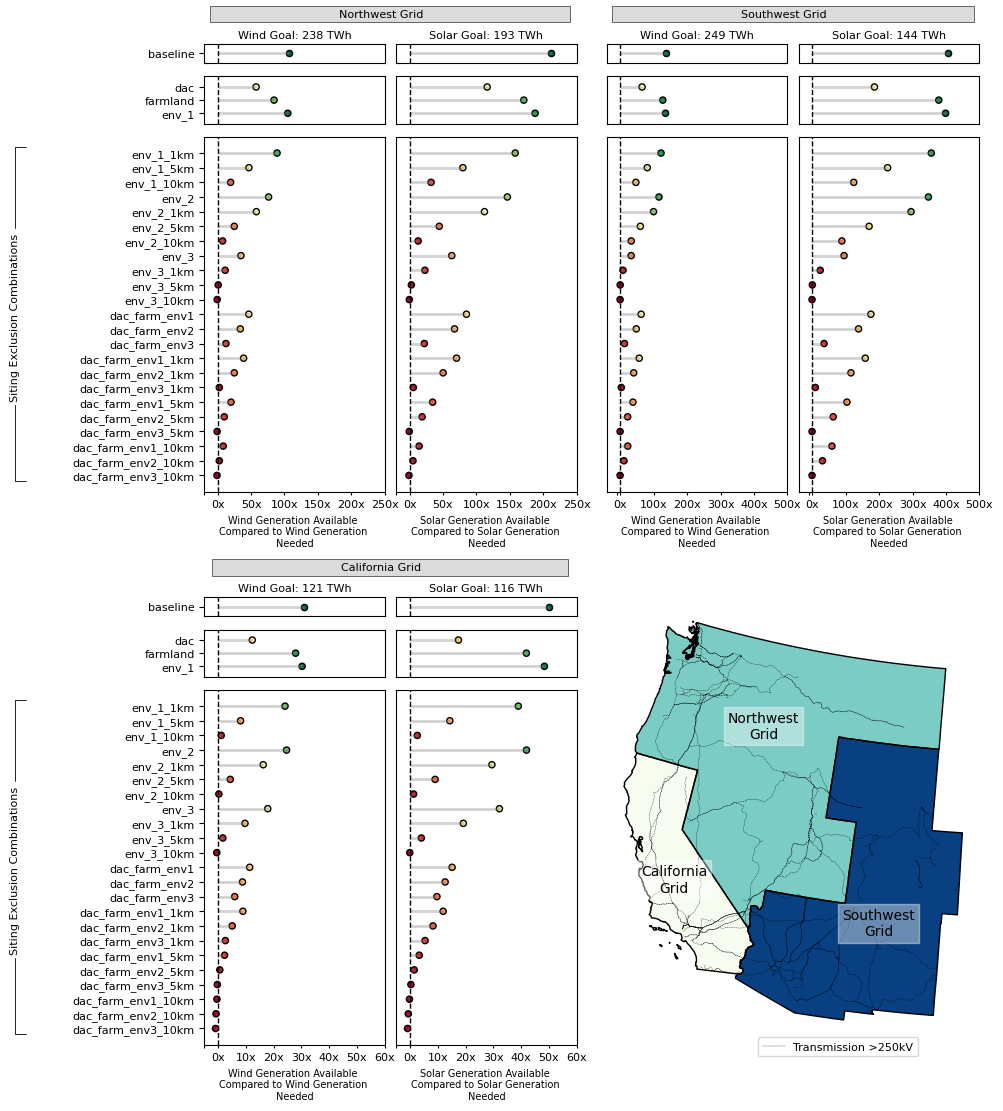

In [59]:
height = 13
width = 10

fig = plt.figure()
fig.set_figheight(height)
fig.set_figwidth(width)

spec = GridSpec(ncols=5, 
                nrows=7,
                width_ratios=[.25, .25, .01 , .25,.25], 
                wspace=0.08,
                hspace=0.1,
                height_ratios=[.05, .12, .9, .2, .05, .12, .9])


# top row set
ax_1a1 =fig.add_subplot(spec[0,0])
ax_1a2 =fig.add_subplot(spec[1,0])
ax_1a3 =fig.add_subplot(spec[2,0])

ax_1b1 =fig.add_subplot(spec[0,1])
ax_1b2 =fig.add_subplot(spec[1,1])
ax_1b3 =fig.add_subplot(spec[2,1])


# sw grid wind
ax_2a1 =fig.add_subplot(spec[0,3])
ax_2a2 =fig.add_subplot(spec[1,3])
ax_2a3 =fig.add_subplot(spec[2,3])

# sw grid solar
ax_2b1 =fig.add_subplot(spec[0,4])
ax_2b2 =fig.add_subplot(spec[1,4])
ax_2b3 =fig.add_subplot(spec[2,4])

# filler row
ax_filler = fig.add_subplot(spec[3,:])

# second row set
# ca wind
ax_3a1 =fig.add_subplot(spec[4,0])
ax_3a2 =fig.add_subplot(spec[5,0])
ax_3a3 =fig.add_subplot(spec[6,0])

# ca solar
ax_3b1 =fig.add_subplot(spec[4,1])
ax_3b2 =fig.add_subplot(spec[5,1])
ax_3b3 =fig.add_subplot(spec[6,1])

#map
ax_map =fig.add_subplot(spec[4:,3:])


### Settings ###
dot_cmap = 'RdYlGn'
dot_edgecolor = 'black'
dot_size=20
hline_alpha=.35
hlinew = 2
hlinecolor='grey'

###########################
##### Northwest Grid ######
###########################

x=1.03
y=2.75
ax_1a1.annotate(f"                                    Northwest Grid                                         ", 
               xy=(x, y), xytext=(x, y), xycoords='axes fraction', 
                    fontsize=8, ha='center', va='top', bbox=dict(boxstyle='square', fc='lightgray', 
                                                                 lw=.5, alpha=.8, color='black'))
# --------------------
### Northwest WIND ###
# --------------------

region = 'NW Grid'
df = wind_trading
plot_df = df[df.gcam_trading_region == region]

x_val_max = plot_df['diff'].max() + 10
x_val_min = plot_df['diff'].min() - 10


vmax =max(plot_df.total_generation_twh.max(), plot_df.target_generation_twh.max())

# Baseline dots
plot_df1 = plot_df[plot_df.case == 'baseline']
my_range=range(1,len(plot_df1.index)+1)
ax=ax_1a1
ax.hlines(y=my_range, xmin=0, xmax=plot_df1['diff'], color=hlinecolor, alpha=hline_alpha, lw=hlinew)
ax.scatter(plot_df1['diff'], my_range, c=plot_df1['total_generation_twh'], s = dot_size, edgecolor=dot_edgecolor, cmap=dot_cmap, vmin=0, vmax=vmax)
ax.axvline(x = 0, linestyle='dashed', color = 'black', lw=1)
ax.set_yticks(my_range)
ax.set_yticklabels(list(plot_df1.case.unique()))
plt.setp(ax.get_yticklabels(), size=8)
ax.tick_params(axis='x',which='both', bottom=True, top=False, labelbottom=True, size=2, labelsize=8)
ax.set_xlim(left=-20, right=250)
ax.annotate(f"Wind Goal: {int(round(plot_df['target_generation_twh'].mean(), 0))} TWh", xy=(.5, 1.03), xytext=(.5, 1.7), xycoords='axes fraction', 
                    fontsize=8, ha='center', va='top')
ax.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False, size=2, labelsize=8)

# Existing dots
plot_df2 = plot_df[plot_df.case.isin(['dac', 'farmland', 'env_1'])]
my_range=range(1,len(plot_df2.index)+1)
ax=ax_1a2
ax.hlines(y=my_range, xmin=0, xmax=plot_df2['diff'], color=hlinecolor, alpha=hline_alpha, lw=hlinew)
ax.scatter(plot_df2['diff'], my_range, c=plot_df2['total_generation_twh'], s = dot_size, edgecolor=dot_edgecolor, cmap=dot_cmap, vmin=0, vmax=vmax)
ax.axvline(x = 0, linestyle='dashed', color = 'black', lw=1)
ax.set_yticks(my_range)
ax.set_yticklabels(list(plot_df2.case.unique()))
plt.setp(ax.get_yticklabels(), size=8)
ax.set_xlim(left=-20, right=250)
ax.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False, size=2, labelsize=8)
ax.margins(0.4)  

# Contribution dots
plot_df3 = plot_df[~plot_df.case.isin(['baseline', 'dac', 'farmland', 'env_1'])]
my_range=range(1,len(plot_df3.index)+1)
ax=ax_1a3
ax.hlines(y=my_range, xmin=0, xmax=plot_df3['diff'], color=hlinecolor, alpha=hline_alpha, lw=hlinew)
ax.scatter(plot_df3['diff'], my_range, c=plot_df3['total_generation_twh'], s = dot_size, edgecolor=dot_edgecolor, alpha=1 , cmap=dot_cmap, vmin=0, vmax=vmax)
ax.axvline(x = 0, linestyle='dashed', color = 'black', lw=1)
ax.set_yticks(my_range)
ax.set_yticklabels(list(plot_df3.case.unique()))
plt.setp(ax.get_yticklabels(), size=8)
ax.tick_params(axis='x',which='both', bottom=True, top=False, labelbottom=True, size=2, labelsize=8)
ax.set_xlim(left=-20, right=250)
ax.set_xticks(ticks=[-20,0,50, 100, 150, 200, 250], labels=['','0x','50x', '100x', '150x', '200x', '250x'])

#######

# --------------------
### Northwest SOLAR ###
# --------------------

region = 'NW Grid'
df = solar_trading
plot_df = df[df.gcam_trading_region == region]

x_val_max = plot_df['diff'].max() + 10
x_val_min = plot_df['diff'].min() - 10


vmax =max(plot_df.total_generation_twh.max(), plot_df.target_generation_twh.max())

# Baseline dots
plot_df1 = plot_df[plot_df.case == 'baseline']
my_range=range(1,len(plot_df1.index)+1)
ax=ax_1b1
ax.hlines(y=my_range, xmin=0, xmax=plot_df1['diff'], color=hlinecolor, alpha=hline_alpha, lw=hlinew)
ax.scatter(plot_df1['diff'], my_range, c=plot_df1['total_generation_twh'], s = dot_size, edgecolor=dot_edgecolor, cmap=dot_cmap, vmin=0, vmax=vmax)
ax.axvline(x = 0, linestyle='dashed', color = 'black', lw=1)
ax.set_yticks(my_range)
plt.setp(ax.get_yticklabels(), size=8)
ax.tick_params(axis='x',which='both', bottom=True, top=False, labelbottom=True, size=2, labelsize=8)
ax.tick_params(axis='y',which='both', bottom=False, top=False, left=False, labelleft=False, labelbottom=False)
ax.set_xlim(left=-20, right=250)
ax.annotate(f"Solar Goal: {int(round(plot_df['target_generation_twh'].mean(), 0))} TWh", xy=(.5, 1.03), xytext=(.5, 1.7), xycoords='axes fraction', 
                    fontsize=8, ha='center', va='top')
ax.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False, size=2, labelsize=8)

# Existing dots
plot_df2 = plot_df[plot_df.case.isin(['dac', 'farmland', 'env_1'])]
my_range=range(1,len(plot_df2.index)+1)
ax=ax_1b2
ax.hlines(y=my_range, xmin=0, xmax=plot_df2['diff'], color=hlinecolor, alpha=hline_alpha, lw=hlinew)
ax.scatter(plot_df2['diff'], my_range, c=plot_df2['total_generation_twh'], s = dot_size, edgecolor=dot_edgecolor, cmap=dot_cmap, vmin=0, vmax=vmax)
ax.axvline(x = 0, linestyle='dashed', color = 'black', lw=1)
ax.set_yticks(my_range)
ax.tick_params(axis='y',which='both', bottom=False, top=False, left=False, labelleft=False, labelbottom=False)
plt.setp(ax.get_yticklabels(), size=8)
ax.set_xlim(left=-20, right=250)
ax.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False, size=2, labelsize=8)
ax.margins(0.4)  

# Contribution dots
plot_df3 = plot_df[~plot_df.case.isin(['baseline', 'dac', 'farmland', 'env_1'])]
my_range=range(1,len(plot_df3.index)+1)
ax=ax_1b3
ax.hlines(y=my_range, xmin=0, xmax=plot_df3['diff'], color=hlinecolor, alpha=hline_alpha, lw=hlinew)
ax.scatter(plot_df3['diff'], my_range, c=plot_df3['total_generation_twh'], s = dot_size, edgecolor=dot_edgecolor, alpha=1 , cmap=dot_cmap, vmin=0, vmax=vmax)
ax.axvline(x = 0, linestyle='dashed', color = 'black', lw=1)
ax.set_yticks(my_range)
ax.tick_params(axis='y',which='both', bottom=False, top=False, left=False, labelleft=False, labelbottom=False)
plt.setp(ax.get_yticklabels(), size=8)
ax.tick_params(axis='x',which='both', bottom=True, top=False, labelbottom=True, size=2, labelsize=8)
ax.set_xlim(left=-20, right=250)
ax.set_xticks(ticks=[-20,0,50, 100, 150, 200, 250], labels=['','0x','50x', '100x', '150x', '200x', '250x'])

#######

###########################
##### Southwest Grid ######
###########################

x=1.03
y=2.75
ax_2a1.annotate(f"                                    Southwest Grid                                         ", 
               xy=(x, y), xytext=(x, y), xycoords='axes fraction', 
                    fontsize=8, ha='center', va='top', bbox=dict(boxstyle='square', fc='lightgray', 
                                                                 lw=.5, alpha=.8, color='black'))
# --------------------
### Southwest WIND ###
# --------------------

region = 'SW Grid'
df = wind_trading
plot_df = df[df.gcam_trading_region == region]

x_val_max = plot_df['diff'].max() + 10
x_val_min = plot_df['diff'].min() - 10


vmax =max(plot_df.total_generation_twh.max(), plot_df.target_generation_twh.max())

# Baseline dots
plot_df1 = plot_df[plot_df.case == 'baseline']
my_range=range(1,len(plot_df1.index)+1)
ax=ax_2a1
ax.hlines(y=my_range, xmin=0, xmax=plot_df1['diff'], color=hlinecolor, alpha=hline_alpha, lw=hlinew)
ax.scatter(plot_df1['diff'], my_range, c=plot_df1['total_generation_twh'], s = dot_size, edgecolor=dot_edgecolor, cmap=dot_cmap, vmin=0, vmax=vmax)
ax.axvline(x = 0, linestyle='dashed', color = 'black', lw=1)
ax.set_yticks(my_range)
ax.tick_params(axis='x',which='both', bottom=True, top=False, labelbottom=True, size=2, labelsize=8)
ax.tick_params(axis='y',which='both', bottom=False, top=False, left=False, labelleft=False, labelbottom=False)
ax.set_xlim(left=-40, right=500)
ax.annotate(f"Wind Goal: {int(round(plot_df['target_generation_twh'].mean(), 0))} TWh", xy=(.5, 1.03), xytext=(.5, 1.7), xycoords='axes fraction', 
                    fontsize=8, ha='center', va='top')
ax.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False, size=2, labelsize=8)

# Existing dots
plot_df2 = plot_df[plot_df.case.isin(['dac', 'farmland', 'env_1'])]
my_range=range(1,len(plot_df2.index)+1)
ax=ax_2a2
ax.hlines(y=my_range, xmin=0, xmax=plot_df2['diff'], color=hlinecolor, alpha=hline_alpha, lw=hlinew)
ax.scatter(plot_df2['diff'], my_range, c=plot_df2['total_generation_twh'], s = dot_size, edgecolor=dot_edgecolor, cmap=dot_cmap, vmin=0, vmax=vmax)
ax.axvline(x = 0, linestyle='dashed', color = 'black', lw=1)
ax.set_yticks(my_range)
ax.set_xlim(left=-40, right=500)
ax.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False, size=2, labelsize=8)
ax.tick_params(axis='y',which='both', bottom=False, top=False, left=False, labelleft=False, labelbottom=False)
ax.margins(0.4)  

# Contribution dots
plot_df3 = plot_df[~plot_df.case.isin(['baseline', 'dac', 'farmland', 'env_1'])]
my_range=range(1,len(plot_df3.index)+1)
ax=ax_2a3
ax.hlines(y=my_range, xmin=0, xmax=plot_df3['diff'], color=hlinecolor, alpha=hline_alpha, lw=hlinew)
ax.scatter(plot_df3['diff'], my_range, c=plot_df3['total_generation_twh'], s = dot_size, edgecolor=dot_edgecolor, alpha=1 , cmap=dot_cmap, vmin=0, vmax=vmax)
ax.axvline(x = 0, linestyle='dashed', color = 'black', lw=1)
ax.set_yticks(my_range)
ax.tick_params(axis='x',which='both', bottom=True, top=False, labelbottom=True, size=2, labelsize=8)
ax.tick_params(axis='y',which='both', bottom=False, top=False, left=False, labelleft=False, labelbottom=False)
ax.set_xlim(left=-40, right=500)
ax.set_xticks(ticks=[-10, 0, 100, 200, 300, 400, 500], labels=['','0x', '100x', '200x', '300x', '400x', '500x'])

#######

# --------------------
### Southwest SOLAR ###
# --------------------

df = solar_trading
plot_df = df[df.gcam_trading_region == region]

x_val_max = plot_df['diff'].max() + 10
x_val_min = plot_df['diff'].min() - 10


vmax =max(plot_df.total_generation_twh.max(), plot_df.target_generation_twh.max())

# Baseline dots
plot_df1 = plot_df[plot_df.case == 'baseline']
my_range=range(1,len(plot_df1.index)+1)
ax=ax_2b1
ax.hlines(y=my_range, xmin=0, xmax=plot_df1['diff'], color=hlinecolor, alpha=hline_alpha, lw=hlinew)
ax.scatter(plot_df1['diff'], my_range, c=plot_df1['total_generation_twh'], s = dot_size, edgecolor=dot_edgecolor, cmap=dot_cmap, vmin=0, vmax=vmax)
ax.axvline(x = 0, linestyle='dashed', color = 'black', lw=1)
ax.set_yticks(my_range)
plt.setp(ax.get_yticklabels(), size=8)
ax.tick_params(axis='x',which='both', bottom=True, top=False, labelbottom=True, size=2, labelsize=8)
ax.tick_params(axis='y',which='both', bottom=False, top=False, left=False, labelleft=False, labelbottom=False)
ax.set_xlim(left=-40, right=500)
ax.annotate(f"Solar Goal: {int(round(plot_df['target_generation_twh'].mean(), 0))} TWh", xy=(.5, 1.03), xytext=(.5, 1.7), xycoords='axes fraction', 
                    fontsize=8, ha='center', va='top')
ax.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False, size=2, labelsize=8)

# Existing dots
plot_df2 = plot_df[plot_df.case.isin(['dac', 'farmland', 'env_1'])]
my_range=range(1,len(plot_df2.index)+1)
ax=ax_2b2
ax.hlines(y=my_range, xmin=0, xmax=plot_df2['diff'], color=hlinecolor, alpha=hline_alpha, lw=hlinew)
ax.scatter(plot_df2['diff'], my_range, c=plot_df2['total_generation_twh'], s = dot_size, edgecolor=dot_edgecolor, cmap=dot_cmap, vmin=0, vmax=vmax)
ax.axvline(x = 0, linestyle='dashed', color = 'black', lw=1)
ax.set_yticks(my_range)
ax.tick_params(axis='y',which='both', bottom=False, top=False, left=False, labelleft=False, labelbottom=False)
plt.setp(ax.get_yticklabels(), size=8)
ax.set_xlim(left=-40, right=500)
ax.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False, size=2, labelsize=8)
ax.margins(0.4)  

# Contribution dots
plot_df3 = plot_df[~plot_df.case.isin(['baseline', 'dac', 'farmland', 'env_1'])]
my_range=range(1,len(plot_df3.index)+1)
ax=ax_2b3
ax.hlines(y=my_range, xmin=0, xmax=plot_df3['diff'], color=hlinecolor, alpha=hline_alpha, lw=hlinew)
ax.scatter(plot_df3['diff'], my_range, c=plot_df3['total_generation_twh'], s = dot_size, edgecolor=dot_edgecolor, alpha=1 , cmap=dot_cmap, vmin=0, vmax=vmax)
ax.axvline(x = 0, linestyle='dashed', color = 'black', lw=1)
ax.set_yticks(my_range)
ax.tick_params(axis='y',which='both', bottom=False, top=False, left=False, labelleft=False, labelbottom=False)
plt.setp(ax.get_yticklabels(), size=8)
ax.tick_params(axis='x',which='both', bottom=True, top=False, labelbottom=True, size=2, labelsize=8)
ax.set_xlim(left=-40, right=500)
ax.set_xticks(ticks=[-10, 0, 100, 200, 300, 400, 500], labels=['','0x', '100x', '200x', '300x', '400x', '500x'])


###########################
##### CA Grid ######
###########################

x=1.03
y=2.75
ax_3a1.annotate(f"                                    California Grid                                         ", 
               xy=(x, y), xytext=(x, y), xycoords='axes fraction', 
                    fontsize=8, ha='center', va='top', bbox=dict(boxstyle='square', fc='lightgray', 
                                                                 lw=.5, alpha=.8, color='black'))
# --------------------
### CA WIND ###
# --------------------

region = 'CA Grid'
df = wind_trading
plot_df = df[df.gcam_trading_region == region]

x_val_max = plot_df['diff'].max() + 10
x_val_min = plot_df['diff'].min() - 10


vmax =max(plot_df.total_generation_twh.max(), plot_df.target_generation_twh.max())

# Baseline dots
plot_df1 = plot_df[plot_df.case == 'baseline']
my_range=range(1,len(plot_df1.index)+1)
ax=ax_3a1
ax.hlines(y=my_range, xmin=0, xmax=plot_df1['diff'], color=hlinecolor, alpha=hline_alpha, lw=hlinew)
ax.scatter(plot_df1['diff'], my_range, c=plot_df1['total_generation_twh'], s = dot_size, edgecolor=dot_edgecolor, cmap=dot_cmap, vmin=0, vmax=vmax)
ax.axvline(x = 0, linestyle='dashed', color = 'black', lw=1)
ax.set_yticks(my_range)
ax.set_yticklabels(list(plot_df1.case.unique()))
plt.setp(ax.get_yticklabels(), size=8)
ax.tick_params(axis='x',which='both', bottom=True, top=False, labelbottom=True, size=2, labelsize=8)
ax.set_xlim(left=-5, right=60)
ax.annotate(f"Wind Goal: {int(round(plot_df['target_generation_twh'].mean(), 0))} TWh", xy=(.5, 1.03), xytext=(.5, 1.7), xycoords='axes fraction', 
                    fontsize=8, ha='center', va='top')
ax.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False, size=2, labelsize=8)

# Existing dots
plot_df2 = plot_df[plot_df.case.isin(['dac', 'farmland', 'env_1'])]
my_range=range(1,len(plot_df2.index)+1)
ax=ax_3a2
ax.hlines(y=my_range, xmin=0, xmax=plot_df2['diff'], color=hlinecolor, alpha=hline_alpha, lw=hlinew)
ax.scatter(plot_df2['diff'], my_range, c=plot_df2['total_generation_twh'], s = dot_size, edgecolor=dot_edgecolor, cmap=dot_cmap, vmin=0, vmax=vmax)
ax.axvline(x = 0, linestyle='dashed', color = 'black', lw=1)
ax.set_yticks(my_range)
ax.set_yticklabels(list(plot_df2.case.unique()))
plt.setp(ax.get_yticklabels(), size=8)
ax.set_xlim(left=-5, right=60)
ax.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False, size=2, labelsize=8)
ax.margins(0.4)  

# Contribution dots
plot_df3 = plot_df[~plot_df.case.isin(['baseline', 'dac', 'farmland', 'env_1'])]
my_range=range(1,len(plot_df3.index)+1)
ax=ax_3a3
ax.hlines(y=my_range, xmin=0, xmax=plot_df3['diff'], color=hlinecolor, alpha=hline_alpha, lw=hlinew)
ax.scatter(plot_df3['diff'], my_range, c=plot_df3['total_generation_twh'], s = dot_size, edgecolor=dot_edgecolor, alpha=1 , cmap=dot_cmap, vmin=0, vmax=vmax)
ax.axvline(x = 0, linestyle='dashed', color = 'black', lw=1)
ax.set_yticks(my_range)
ax.set_yticklabels(list(plot_df3.case.unique()))
plt.setp(ax.get_yticklabels(), size=8)
ax.tick_params(axis='x',which='both', bottom=True, top=False, labelbottom=True, size=2, labelsize=8)
ax.set_xlim(left=-5, right=60)
ax.set_xticks(ticks=[-5,0, 10, 20, 30, 40, 50, 60], labels=['','0x', '10x','20x', '30x','40x', '50x', '60x'])

#######

# --------------------
### CA SOLAR ###
# --------------------

df = solar_trading
plot_df = df[df.gcam_trading_region == region]

x_val_max = plot_df['diff'].max() + 10
x_val_min = plot_df['diff'].min() - 10


vmax =max(plot_df.total_generation_twh.max(), plot_df.target_generation_twh.max())

# Baseline dots
plot_df1 = plot_df[plot_df.case == 'baseline']
my_range=range(1,len(plot_df1.index)+1)
ax=ax_3b1
ax.hlines(y=my_range, xmin=0, xmax=plot_df1['diff'], color=hlinecolor, alpha=hline_alpha, lw=hlinew)
ax.scatter(plot_df1['diff'], my_range, c=plot_df1['total_generation_twh'], s = dot_size, edgecolor=dot_edgecolor, cmap=dot_cmap, vmin=0, vmax=vmax)
ax.axvline(x = 0, linestyle='dashed', color = 'black', lw=1)
ax.set_yticks(my_range)
plt.setp(ax.get_yticklabels(), size=8)
ax.tick_params(axis='x',which='both', bottom=True, top=False, labelbottom=True, size=2, labelsize=8)
ax.tick_params(axis='y',which='both', bottom=False, top=False, left=False, labelleft=False, labelbottom=False)
ax.set_xlim(left=-5, right=60)
ax.annotate(f"Solar Goal: {int(round(plot_df['target_generation_twh'].mean(), 0))} TWh", xy=(.5, 1.03), xytext=(.5, 1.7), xycoords='axes fraction', 
                    fontsize=8, ha='center', va='top')
ax.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False, size=2, labelsize=8)

# Existing dots
plot_df2 = plot_df[plot_df.case.isin(['dac', 'farmland', 'env_1'])]
my_range=range(1,len(plot_df2.index)+1)
ax=ax_3b2
ax.hlines(y=my_range, xmin=0, xmax=plot_df2['diff'], color=hlinecolor, alpha=hline_alpha, lw=hlinew)
ax.scatter(plot_df2['diff'], my_range, c=plot_df2['total_generation_twh'], s = dot_size, edgecolor=dot_edgecolor, cmap=dot_cmap, vmin=0, vmax=vmax)
ax.axvline(x = 0, linestyle='dashed', color = 'black', lw=1)
ax.set_yticks(my_range)
ax.tick_params(axis='y',which='both', bottom=False, top=False, left=False, labelleft=False, labelbottom=False)
plt.setp(ax.get_yticklabels(), size=8)
ax.set_xlim(left=-5, right=60)
ax.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False, size=2, labelsize=8)
ax.margins(0.4)  

# Contribution dots
plot_df3 = plot_df[~plot_df.case.isin(['baseline', 'dac', 'farmland', 'env_1'])]
my_range=range(1,len(plot_df3.index)+1)
ax=ax_3b3
ax.hlines(y=my_range, xmin=0, xmax=plot_df3['diff'], color=hlinecolor, alpha=hline_alpha, lw=hlinew)
ax.scatter(plot_df3['diff'], my_range, c=plot_df3['total_generation_twh'], s = dot_size, edgecolor=dot_edgecolor, alpha=1 , cmap=dot_cmap, vmin=0, vmax=vmax)
ax.axvline(x = 0, linestyle='dashed', color = 'black', lw=1)
ax.set_yticks(my_range)
ax.tick_params(axis='y',which='both', bottom=False, top=False, left=False, labelleft=False, labelbottom=False)
plt.setp(ax.get_yticklabels(), size=8)
ax.tick_params(axis='x',which='both', bottom=True, top=False, labelbottom=True, size=2, labelsize=8)
ax.set_xlim(left=-5, right=60)
ax.set_xticks(ticks=[-5,0, 10, 20, 30, 40, 50, 60], labels=['','0x', '10x','20x', '30x','40x', '50x', '60x'])

#######


#### MAP #######

volt = Line2D([0], [0], color='black',linestyle='dashed', lw=.25, label='Transmission >250kV')
wecc_shp.plot(ax=ax_map,  column='trading_region', cmap='GnBu')
wecc_shp.boundary.plot(ax=ax_map, lw=1, color='black')
transmission.plot(ax=ax_map, color='black',linestyle='dashed', lw=.25)
ax_map.legend(handles=[volt], fontsize=8, title_fontsize = 8, loc='lower right', ncol=1, facecolor='white', bbox_to_anchor=(.85, -.05))


# region labels
ax_map.set_axis_off()
x=.42
y=.75
ax_map.annotate(f"Northwest\nGrid", xy=(x, y), xytext=(x, y), xycoords='axes fraction', 
                    fontsize=10, ha='center', va='top', bbox=dict(boxstyle='square', fc='white', alpha=.4, color='white'))
x=.73
y=.3
ax_map.annotate(f"Southwest\nGrid", xy=(x, y), xytext=(x, y), xycoords='axes fraction', 
                    fontsize=10, ha='center', va='top', bbox=dict(boxstyle='square', fc='white', alpha=.4, color='white'))
x=.18
y=.4 
ax_map.annotate(f"California\nGrid", xy=(x, y), xytext=(x, y), xycoords='axes fraction', 
                    fontsize=10, ha='center', va='top', bbox=dict(boxstyle='square', fc='white', alpha=.4, color='white'))


# X-axis Unit Labels
for ax in [ax_1a3,  ax_2a3, ax_3a3]:
    ax.set_xlabel('Wind Generation Available \nCompared to Wind Generation \nNeeded', size=7)
for ax in [ax_1b3,  ax_2b3, ax_3b3]:
    ax.set_xlabel('Solar Generation Available \nCompared to Solar Generation \nNeeded', size=7)

ax_map.set_axis_off()
ax_filler.set_axis_off()

#### Side labels

ax_1a3.annotate('Siting Exclusion Combinations', xy=(-1.05, .70), xytext=(-1.05, .73), xycoords='axes fraction', 
            fontsize=8, ha='center', va='top', rotation = 90,
            bbox=dict(boxstyle='square', fc='white', color='white'),
            arrowprops=dict(arrowstyle=']-, widthA=15, lengthA=1, angleA=90',lw=.6, color='k'))

ax_3a3.annotate('Siting Exclusion Combinations', xy=(-1.05, .70), xytext=(-1.05, .73), xycoords='axes fraction', 
            fontsize=8, ha='center', va='top', rotation = 90,
            bbox=dict(boxstyle='square', fc='white', color='white'),
            arrowprops=dict(arrowstyle=']-, widthA=15, lengthA=1, angleA=90',lw=.6, color='k'))
plt.savefig(os.path.join(fig_dir, 'fig_si-8_high_power_density_sensitivity_analysis.png'), dpi=300)

plt.show()